In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW # <--- IMPORT AdamW FROM TORCH.OPTIM
from tqdm.auto import tqdm # For progress bars
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
# You might need to install wordcloud: pip install wordcloud
from wordcloud import WordCloud

# Configuration
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128  # Max sequence length for tokenizer
BATCH_SIZE = 16   # Adjust based on your GPU memory
LEARNING_RATE = 5e-5 # Typical fine-tuning learning rate (2e-5, 3e-5, 5e-5)
NUM_EPOCHS = 3    # 2-4 epochs are often enough for fine-tuning
OUTPUT_DIR = "./news_distilbert_finetuned" # Directory to save the model
DATA_FILE_PATH = 'News_Category_Dataset_v3.json' # Path to your dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Original dataset shape: (209527, 6)
Shape after preprocessing: (209527, 4)
Number of unique categories: 42
Train size: 146668
Validation size: 31429
Test size: 31430

--- Starting Exploratory Data Analysis ---

--- 2.1 Basic Statistics & Missing Values ---
Dataset Description:
              headline short_description  category  \
count           209527            209527    209527   
unique          207996            187022        42   
top     Sunday Roundup                    POLITICS   
freq                90             19712     35602   

                                                     text  
count                                              209527  
unique                                             209038  
top     Watch The Top 9 YouTube Videos Of The Week [SE...  
freq                                                   46  

Missing values per column:
headline             0
short_description    0
category             0
text                 0
label_encoded        0
dtype: i

C:\Users\Granbell\AppData\Local\Temp\ipykernel_7624\1568667674.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


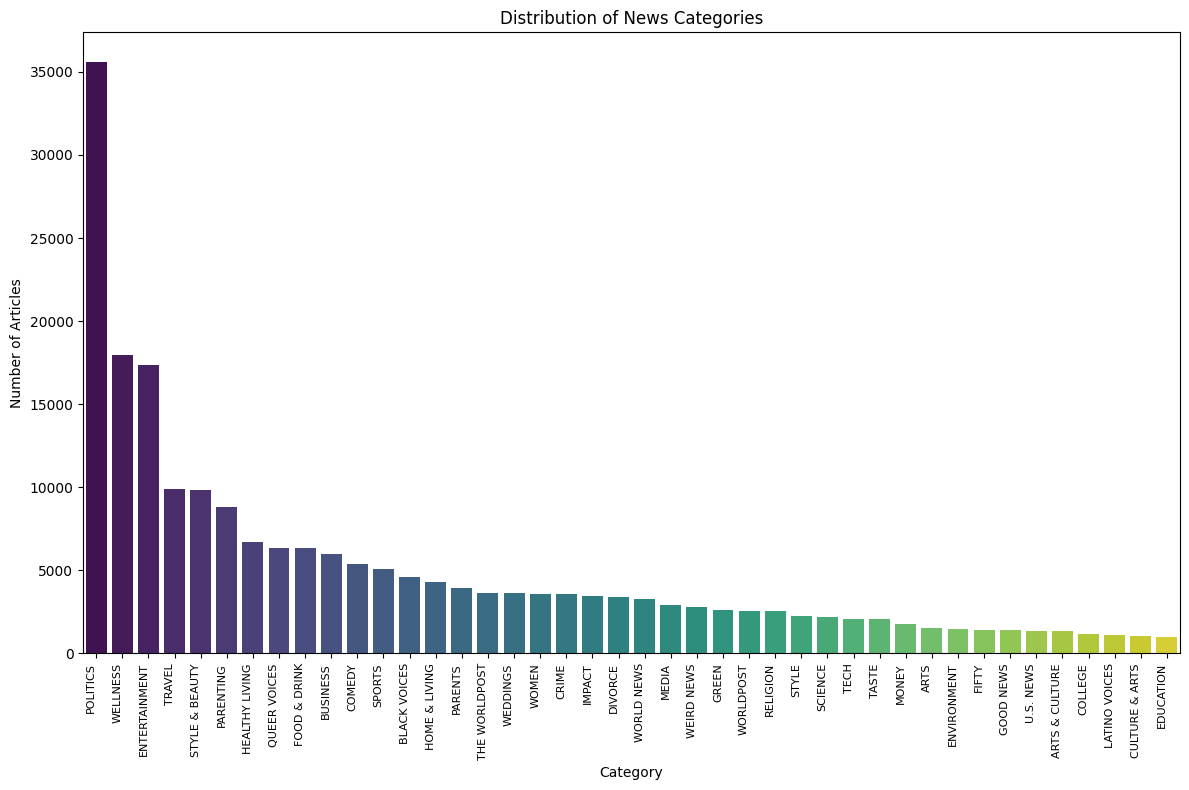


Number of unique categories: 42
Most common category: POLITICS with 35602 articles
Least common category: EDUCATION with 1014 articles

--- 2.3 Text Length Analysis ---


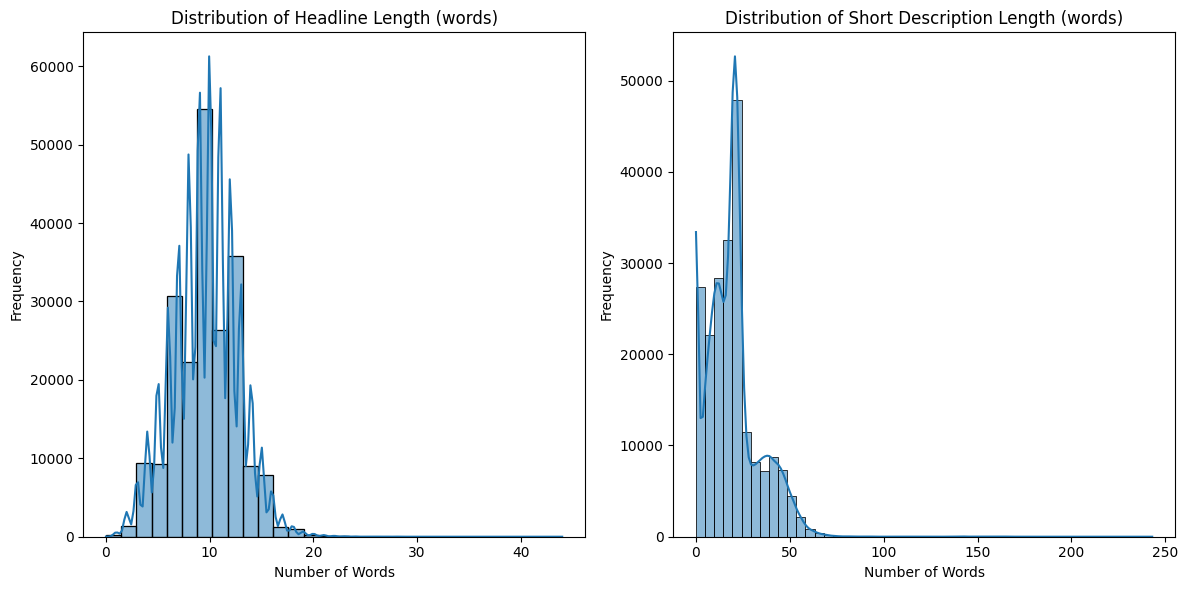


Headline Length Statistics:
count    209527.000000
mean          9.600744
std           3.068507
min           0.000000
25%           8.000000
50%          10.000000
75%          12.000000
max          44.000000
Name: headline_length, dtype: float64

Short Description Length Statistics:
count    209527.000000
mean         19.669026
std          14.152783
min           0.000000
25%          10.000000
50%          19.000000
75%          24.000000
max         243.000000
Name: description_length, dtype: float64

--- 2.4 Word Clouds ---
Generating word clouds for top 3 categories (headline + description)...


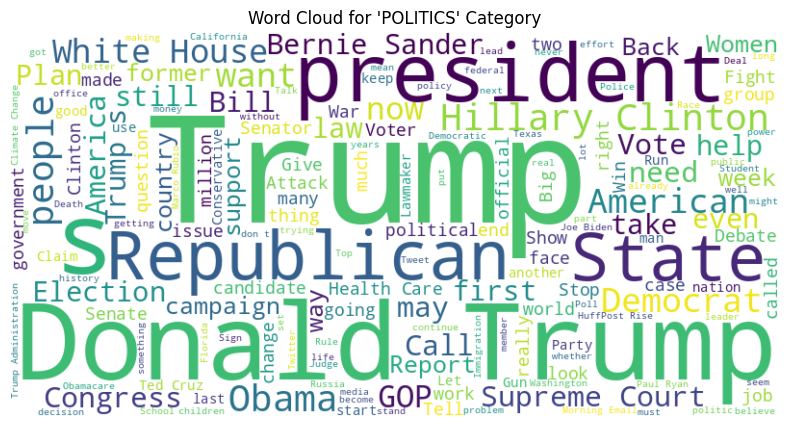

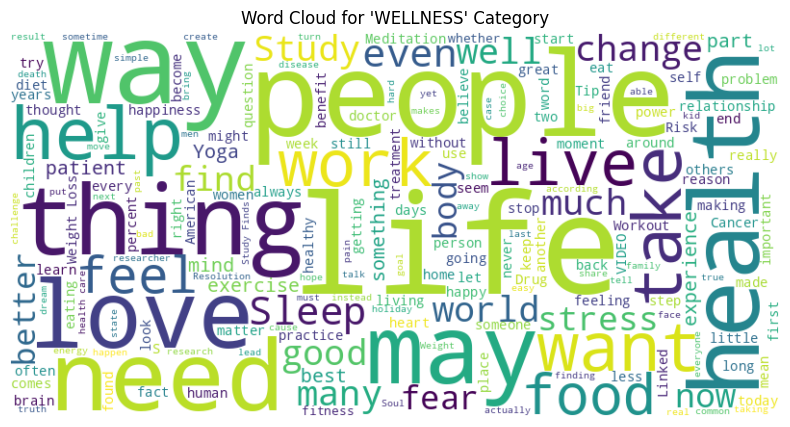

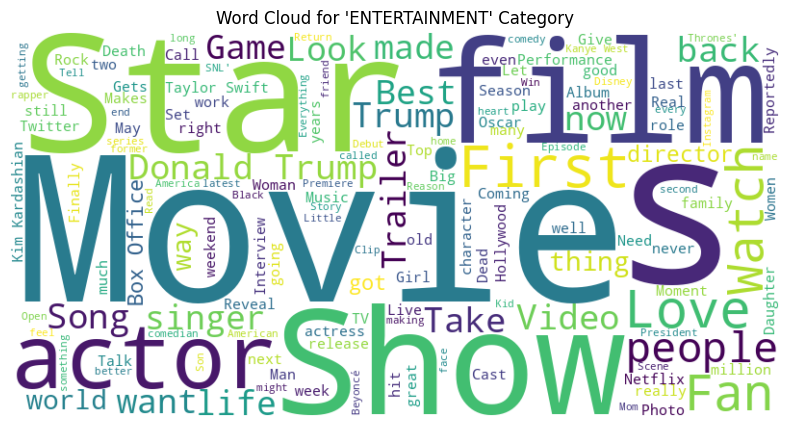


--- 2.5 Author Analysis ---
Column 'authors' not found for analysis.

--- 2.6 Date Analysis (Temporal Trends) ---
Column 'date' not found for analysis.

--- EDA Complete ---


In [4]:
# Load dataset
df = pd.read_json(DATA_FILE_PATH, lines=True)
print(f"Original dataset shape: {df.shape}")

# Select relevant columns and combine text
df = df[['headline', 'short_description', 'category']]
df.dropna(subset=['headline', 'short_description', 'category'], inplace=True)
df['text'] = df['headline'] + " [SEP] " + df['short_description'] # Combine with a separator
print(f"Shape after preprocessing: {df.shape}")

# Optional: For faster iteration, use a subset
# df = df.sample(n=20000, random_state=42)
# print(f"Using subset of shape: {df.shape}")

# Encode labels (categories)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['category'])
num_labels = len(label_encoder.classes_)
print(f"Number of unique categories: {num_labels}")
# Store mapping for later
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.3, # 70% train, 30% for val+test
    random_state=42,
    stratify=df['label_encoded'] # Important for imbalanced classes
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5, # Split the 30% into 15% val and 15% test
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")


# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- Starting Exploratory Data Analysis ---")

# 2.1. Basic Statistics and Missing Values
print("\n--- 2.1 Basic Statistics & Missing Values ---")
print("Dataset Description:")
print(df.describe(include='object')) # Describe object columns

print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows with missing critical values (headline, short_description, category)
# This is also part of your original preprocessing, good to confirm here
df_eda = df.dropna(subset=['headline', 'short_description', 'category']).copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"\nShape after dropping NaNs for EDA: {df_eda.shape}")

# 2.2. Category Distribution
print("\n--- 2.2 Category Distribution ---")
category_counts = df_eda['category'].value_counts()
print("Category Counts:")
print(category_counts)

plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90, ha='right', fontsize=8) # Rotate labels for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print(f"\nNumber of unique categories: {df_eda['category'].nunique()}")
print(f"Most common category: {category_counts.index[0]} with {category_counts.iloc[0]} articles")
print(f"Least common category: {category_counts.index[-1]} with {category_counts.iloc[-1]} articles")

# 2.3. Text Length Analysis
print("\n--- 2.3 Text Length Analysis ---")
df_eda['headline_length'] = df_eda['headline'].apply(lambda x: len(x.split()))
df_eda['description_length'] = df_eda['short_description'].apply(lambda x: len(str(x).split())) # str(x) to handle potential non-strings if any survived dropna

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_eda['headline_length'], kde=True, bins=30)
plt.title('Distribution of Headline Length (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_eda['description_length'], kde=True, bins=50)
plt.title('Distribution of Short Description Length (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\nHeadline Length Statistics:")
print(df_eda['headline_length'].describe())
print("\nShort Description Length Statistics:")
print(df_eda['description_length'].describe())

# 2.4. Word Clouds (for a few top categories)
print("\n--- 2.4 Word Clouds ---")
# Consider common English stop words
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["said", "will", "new", "one", "u", "us", "say", "says", "told", "year", "day", "time", "make", "get", "go", "know", "see", "come", "think"]) # Add custom stopwords

def generate_wordcloud(text_series, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(" ".join(text_series))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

print("Generating word clouds for top 3 categories (headline + description)...")
top_categories = category_counts.index[:3]
for category_name in top_categories:
    category_df = df_eda[df_eda['category'] == category_name]
    combined_text = category_df['headline'] + " " + category_df['short_description']
    generate_wordcloud(combined_text, f"Word Cloud for '{category_name}' Category")


# 2.5. Analysis of Authors (if interesting and not too many unique authors)
print("\n--- 2.5 Author Analysis ---")
if 'authors' in df_eda.columns:
    author_counts = df_eda['authors'].value_counts()
    print(f"Number of unique authors/author groups: {df_eda['authors'].nunique()}")
    if df_eda['authors'].nunique() < 200: # Only plot if manageable number
        print("\nTop 10 Authors/Author Groups:")
        print(author_counts.head(10))
        plt.figure(figsize=(10, 6))
        author_counts.head(10).plot(kind='bar')
        plt.title('Top 10 Authors/Author Groups by Number of Articles')
        plt.xlabel('Author(s)')
        plt.ylabel('Number of Articles')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("Too many unique authors to plot directly. Top 10:")
        print(author_counts.head(10))
else:
    print("Column 'authors' not found for analysis.")


# 2.6. Date Analysis (Temporal Trends)
print("\n--- 2.6 Date Analysis (Temporal Trends) ---")
if 'date' in df_eda.columns:
    df_eda['date'] = pd.to_datetime(df_eda['date'])
    df_eda.set_index('date', inplace=True) # Set date as index for easy resampling

    articles_per_month = df_eda.resample('M').size() # 'M' for month end frequency
    plt.figure(figsize=(12, 6))
    articles_per_month.plot()
    plt.title('Number of Articles Published Over Time (Monthly)')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.grid(True)
    plt.show()

    print("\nArticles per year:")
    print(df_eda.resample('Y').size())

    # Reset index if you need 'date' as a column later for modeling features
    df_eda.reset_index(inplace=True)
else:
    print("Column 'date' not found for analysis.")


print("\n--- EDA Complete ---")
# At this point, df_eda contains your cleaned data with some new length features.
# For the rest of the modeling, you might want to revert to a cleaner df or use df_eda
# The original script used 'df' and re-did the dropna and text combination.
# We will proceed with 'df' as per the original script's structure.
# Re-assign 'df' to the cleaned version for consistency with the rest of your script
df = df_eda.copy() # Or use df_eda directly if you prefer

In [6]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# Tokenize texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LENGTH)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LENGTH)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=MAX_LENGTH)

# Create PyTorch Dataset
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)
test_dataset = NewsDataset(test_encodings, test_labels)



In [7]:
# Load DistilBERT for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels # Crucial: number of output classes
)
model.to(device) # Move model to GPU if available

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", # or "cosine"
    optimizer=optimizer,
    num_warmup_steps=0, # You can set a warmup period if desired
    num_training_steps=num_training_steps
)

# Helper function for metrics
def compute_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted') # 'weighted' for multi-class
    return {"accuracy": accuracy, "f1_weighted": f1}

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
progress_bar_train = tqdm(range(num_training_steps))
best_val_f1 = 0.0 # To save the best model based on validation F1

for epoch in range(NUM_EPOCHS):
    # --- Training ---
    model.train()
    total_train_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar_train.update(1)

        if (batch_idx + 1) % 100 == 0: # Log every 100 batches
            print(f"  Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_dataloader)}, Train Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    print(f"  Average Training Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    print("  Validating...")
    progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation")
    for batch in progress_bar_val:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_val_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_val_preds.extend(predictions.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_metrics = compute_metrics(all_val_preds, all_val_labels)
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}, Validation F1 (Weighted): {val_metrics['f1_weighted']:.4f}")

    # Save the model if it has the best validation F1 so far
    if val_metrics['f1_weighted'] > best_val_f1:
        best_val_f1 = val_metrics['f1_weighted']
        print(f"  New best validation F1: {best_val_f1:.4f}. Saving model...")
        model.save_pretrained(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)
        # Save label encoder and map
        import pickle
        with open(f"{OUTPUT_DIR}/label_encoder.pkl", "wb") as f:
            pickle.dump(label_encoder, f)
        # with open(f"{OUTPUT_DIR}/label_map.pkl", "wb") as f: # Not strictly needed if encoder is saved
        #     pickle.dump(label_map, f)
    print("-" * 50)

print("Training complete!")

  0%|▎                                                                             | 102/27501 [00:14<59:35,  7.66it/s]

  Epoch 1, Batch 100/9167, Train Loss: 2.2156


  1%|▌                                                                           | 202/27501 [00:27<1:00:00,  7.58it/s]

  Epoch 1, Batch 200/9167, Train Loss: 1.9859


  1%|▊                                                                             | 302/27501 [00:40<59:38,  7.60it/s]

  Epoch 1, Batch 300/9167, Train Loss: 2.1459


  1%|█▏                                                                            | 402/27501 [00:53<59:43,  7.56it/s]

  Epoch 1, Batch 400/9167, Train Loss: 2.1011


  2%|█▍                                                                          | 502/27501 [01:07<1:00:45,  7.41it/s]

  Epoch 1, Batch 500/9167, Train Loss: 1.5791


  2%|█▋                                                                          | 602/27501 [01:20<1:00:07,  7.46it/s]

  Epoch 1, Batch 600/9167, Train Loss: 1.1632


  3%|█▉                                                                          | 702/27501 [01:33<1:00:07,  7.43it/s]

  Epoch 1, Batch 700/9167, Train Loss: 1.8011


  3%|██▏                                                                         | 802/27501 [01:47<1:00:07,  7.40it/s]

  Epoch 1, Batch 800/9167, Train Loss: 1.8814


  3%|██▍                                                                         | 902/27501 [02:00<1:00:18,  7.35it/s]

  Epoch 1, Batch 900/9167, Train Loss: 1.3565


  4%|██▋                                                                        | 1002/27501 [02:14<1:00:11,  7.34it/s]

  Epoch 1, Batch 1000/9167, Train Loss: 1.1116


  4%|███                                                                        | 1102/27501 [02:28<1:00:06,  7.32it/s]

  Epoch 1, Batch 1100/9167, Train Loss: 1.6861


  4%|███▎                                                                       | 1202/27501 [02:42<1:00:03,  7.30it/s]

  Epoch 1, Batch 1200/9167, Train Loss: 1.4387


  5%|███▌                                                                       | 1301/27501 [02:55<1:02:25,  6.99it/s]

  Epoch 1, Batch 1300/9167, Train Loss: 1.7068


  5%|███▊                                                                       | 1401/27501 [03:10<1:26:40,  5.02it/s]

  Epoch 1, Batch 1400/9167, Train Loss: 1.4796


  5%|████                                                                       | 1501/27501 [03:30<1:20:57,  5.35it/s]

  Epoch 1, Batch 1500/9167, Train Loss: 1.1747


  6%|████▎                                                                      | 1601/27501 [03:50<2:02:42,  3.52it/s]

  Epoch 1, Batch 1600/9167, Train Loss: 1.1478


  6%|████▋                                                                      | 1701/27501 [04:06<1:06:13,  6.49it/s]

  Epoch 1, Batch 1700/9167, Train Loss: 1.6560


  7%|████▉                                                                      | 1801/27501 [04:21<1:04:32,  6.64it/s]

  Epoch 1, Batch 1800/9167, Train Loss: 1.1045


  7%|█████▏                                                                     | 1901/27501 [04:53<1:11:43,  5.95it/s]

  Epoch 1, Batch 1900/9167, Train Loss: 1.5104


  7%|█████▍                                                                     | 2001/27501 [05:10<1:10:42,  6.01it/s]

  Epoch 1, Batch 2000/9167, Train Loss: 2.0462


  8%|█████▋                                                                     | 2101/27501 [05:27<1:11:17,  5.94it/s]

  Epoch 1, Batch 2100/9167, Train Loss: 0.9610


  8%|██████                                                                     | 2201/27501 [05:43<1:11:16,  5.92it/s]

  Epoch 1, Batch 2200/9167, Train Loss: 1.1072


  8%|██████▎                                                                    | 2301/27501 [06:00<1:09:32,  6.04it/s]

  Epoch 1, Batch 2300/9167, Train Loss: 1.5912


  9%|██████▌                                                                    | 2401/27501 [06:16<1:09:57,  5.98it/s]

  Epoch 1, Batch 2400/9167, Train Loss: 1.6496


  9%|██████▊                                                                    | 2501/27501 [06:33<1:09:14,  6.02it/s]

  Epoch 1, Batch 2500/9167, Train Loss: 0.7976


  9%|███████                                                                    | 2601/27501 [06:50<1:09:14,  5.99it/s]

  Epoch 1, Batch 2600/9167, Train Loss: 1.4215


 10%|███████▎                                                                   | 2701/27501 [07:06<1:08:44,  6.01it/s]

  Epoch 1, Batch 2700/9167, Train Loss: 1.4929


 10%|███████▋                                                                   | 2801/27501 [07:23<1:08:52,  5.98it/s]

  Epoch 1, Batch 2800/9167, Train Loss: 1.0581


 11%|███████▉                                                                   | 2901/27501 [07:39<1:07:46,  6.05it/s]

  Epoch 1, Batch 2900/9167, Train Loss: 1.0879


 11%|████████▏                                                                  | 3001/27501 [07:56<1:08:09,  5.99it/s]

  Epoch 1, Batch 3000/9167, Train Loss: 0.7759


 11%|████████▍                                                                  | 3101/27501 [08:12<1:07:24,  6.03it/s]

  Epoch 1, Batch 3100/9167, Train Loss: 0.9450


 12%|████████▋                                                                  | 3201/27501 [08:29<1:07:07,  6.03it/s]

  Epoch 1, Batch 3200/9167, Train Loss: 1.2296


 12%|█████████                                                                  | 3301/27501 [08:45<1:07:11,  6.00it/s]

  Epoch 1, Batch 3300/9167, Train Loss: 2.3329


 12%|█████████▎                                                                 | 3401/27501 [09:02<1:07:12,  5.98it/s]

  Epoch 1, Batch 3400/9167, Train Loss: 1.3023


 13%|█████████▌                                                                 | 3501/27501 [09:19<1:08:59,  5.80it/s]

  Epoch 1, Batch 3500/9167, Train Loss: 0.8760


 13%|█████████▊                                                                 | 3601/27501 [09:35<1:06:13,  6.01it/s]

  Epoch 1, Batch 3600/9167, Train Loss: 1.0890


 13%|██████████                                                                 | 3701/27501 [09:52<1:06:00,  6.01it/s]

  Epoch 1, Batch 3700/9167, Train Loss: 1.2416


 14%|██████████▎                                                                | 3801/27501 [10:08<1:05:45,  6.01it/s]

  Epoch 1, Batch 3800/9167, Train Loss: 1.7603


 14%|██████████▋                                                                | 3901/27501 [10:25<1:07:07,  5.86it/s]

  Epoch 1, Batch 3900/9167, Train Loss: 1.0476


 15%|██████████▉                                                                | 4001/27501 [10:42<1:06:36,  5.88it/s]

  Epoch 1, Batch 4000/9167, Train Loss: 0.5894


 15%|███████████▏                                                               | 4101/27501 [10:59<1:07:59,  5.74it/s]

  Epoch 1, Batch 4100/9167, Train Loss: 1.6134


 15%|███████████▍                                                               | 4201/27501 [11:16<1:06:22,  5.85it/s]

  Epoch 1, Batch 4200/9167, Train Loss: 0.6066


 16%|███████████▋                                                               | 4301/27501 [11:33<1:06:10,  5.84it/s]

  Epoch 1, Batch 4300/9167, Train Loss: 0.9994


 16%|████████████                                                               | 4401/27501 [11:50<1:05:54,  5.84it/s]

  Epoch 1, Batch 4400/9167, Train Loss: 1.3712


 16%|████████████▎                                                              | 4501/27501 [12:07<1:07:54,  5.65it/s]

  Epoch 1, Batch 4500/9167, Train Loss: 0.9605


 17%|████████████▌                                                              | 4601/27501 [12:25<1:06:57,  5.70it/s]

  Epoch 1, Batch 4600/9167, Train Loss: 1.2361


 17%|████████████▊                                                              | 4701/27501 [12:43<1:06:49,  5.69it/s]

  Epoch 1, Batch 4700/9167, Train Loss: 0.9723


 17%|█████████████                                                              | 4801/27501 [13:00<1:06:22,  5.70it/s]

  Epoch 1, Batch 4800/9167, Train Loss: 1.1127


 18%|█████████████▎                                                             | 4901/27501 [13:18<1:06:44,  5.64it/s]

  Epoch 1, Batch 4900/9167, Train Loss: 0.7369


 18%|█████████████▋                                                             | 5001/27501 [13:35<1:07:17,  5.57it/s]

  Epoch 1, Batch 5000/9167, Train Loss: 1.0527


 19%|█████████████▉                                                             | 5101/27501 [13:53<1:07:09,  5.56it/s]

  Epoch 1, Batch 5100/9167, Train Loss: 0.8130


 19%|██████████████▏                                                            | 5201/27501 [14:11<1:06:12,  5.61it/s]

  Epoch 1, Batch 5200/9167, Train Loss: 1.2944


 19%|██████████████▍                                                            | 5301/27501 [14:29<1:03:37,  5.82it/s]

  Epoch 1, Batch 5300/9167, Train Loss: 0.8476


 20%|███████████████                                                              | 5401/27501 [14:59<58:01,  6.35it/s]

  Epoch 1, Batch 5400/9167, Train Loss: 1.0362


 20%|███████████████▍                                                             | 5501/27501 [15:15<59:53,  6.12it/s]

  Epoch 1, Batch 5500/9167, Train Loss: 0.9231


 20%|███████████████▋                                                             | 5601/27501 [15:31<59:32,  6.13it/s]

  Epoch 1, Batch 5600/9167, Train Loss: 1.2778


 21%|███████████████▉                                                             | 5701/27501 [15:47<56:58,  6.38it/s]

  Epoch 1, Batch 5700/9167, Train Loss: 1.1504


 21%|████████████████▏                                                            | 5801/27501 [16:03<56:27,  6.41it/s]

  Epoch 1, Batch 5800/9167, Train Loss: 0.9830


 21%|████████████████▌                                                            | 5901/27501 [16:18<56:06,  6.42it/s]

  Epoch 1, Batch 5900/9167, Train Loss: 2.3620


 22%|████████████████▊                                                            | 6001/27501 [16:34<57:30,  6.23it/s]

  Epoch 1, Batch 6000/9167, Train Loss: 1.2207


 22%|█████████████████                                                            | 6101/27501 [16:49<55:12,  6.46it/s]

  Epoch 1, Batch 6100/9167, Train Loss: 1.3159


 23%|█████████████████▎                                                           | 6201/27501 [17:05<54:57,  6.46it/s]

  Epoch 1, Batch 6200/9167, Train Loss: 1.0350


 23%|█████████████████▋                                                           | 6301/27501 [17:20<55:00,  6.42it/s]

  Epoch 1, Batch 6300/9167, Train Loss: 0.9871


 23%|█████████████████▉                                                           | 6401/27501 [17:36<54:31,  6.45it/s]

  Epoch 1, Batch 6400/9167, Train Loss: 0.7846


 24%|██████████████████▏                                                          | 6501/27501 [17:53<59:45,  5.86it/s]

  Epoch 1, Batch 6500/9167, Train Loss: 1.7447


 24%|██████████████████▍                                                          | 6601/27501 [18:09<54:55,  6.34it/s]

  Epoch 1, Batch 6600/9167, Train Loss: 0.9733


 24%|██████████████████▊                                                          | 6701/27501 [18:25<54:58,  6.31it/s]

  Epoch 1, Batch 6700/9167, Train Loss: 0.7568


 25%|███████████████████                                                          | 6801/27501 [18:41<53:16,  6.48it/s]

  Epoch 1, Batch 6800/9167, Train Loss: 1.1243


 25%|███████████████████▎                                                         | 6901/27501 [18:56<53:03,  6.47it/s]

  Epoch 1, Batch 6900/9167, Train Loss: 1.3772


 25%|███████████████████▌                                                         | 7001/27501 [19:12<53:04,  6.44it/s]

  Epoch 1, Batch 7000/9167, Train Loss: 1.0340


 26%|███████████████████▉                                                         | 7101/27501 [19:27<52:48,  6.44it/s]

  Epoch 1, Batch 7100/9167, Train Loss: 1.5625


 26%|████████████████████▏                                                        | 7201/27501 [19:43<53:20,  6.34it/s]

  Epoch 1, Batch 7200/9167, Train Loss: 0.6921


 27%|███████████████████▉                                                       | 7301/27501 [19:59<1:02:08,  5.42it/s]

  Epoch 1, Batch 7300/9167, Train Loss: 1.1901


 27%|████████████████████▋                                                        | 7401/27501 [20:15<55:44,  6.01it/s]

  Epoch 1, Batch 7400/9167, Train Loss: 1.1772


 27%|█████████████████████                                                        | 7501/27501 [20:31<54:42,  6.09it/s]

  Epoch 1, Batch 7500/9167, Train Loss: 1.5642


 28%|█████████████████████▎                                                       | 7601/27501 [20:47<54:20,  6.10it/s]

  Epoch 1, Batch 7600/9167, Train Loss: 1.0154


 28%|█████████████████████▌                                                       | 7701/27501 [21:03<51:04,  6.46it/s]

  Epoch 1, Batch 7700/9167, Train Loss: 0.7512


 28%|█████████████████████▊                                                       | 7801/27501 [21:19<52:21,  6.27it/s]

  Epoch 1, Batch 7800/9167, Train Loss: 1.2244


 29%|██████████████████████                                                       | 7901/27501 [21:35<53:01,  6.16it/s]

  Epoch 1, Batch 7900/9167, Train Loss: 0.7893


 29%|██████████████████████▍                                                      | 8001/27501 [21:51<52:17,  6.22it/s]

  Epoch 1, Batch 8000/9167, Train Loss: 0.4405


 29%|██████████████████████▋                                                      | 8101/27501 [22:07<50:26,  6.41it/s]

  Epoch 1, Batch 8100/9167, Train Loss: 1.6994


 30%|██████████████████████▉                                                      | 8201/27501 [22:23<50:02,  6.43it/s]

  Epoch 1, Batch 8200/9167, Train Loss: 1.2000


 30%|███████████████████████▏                                                     | 8301/27501 [22:38<49:58,  6.40it/s]

  Epoch 1, Batch 8300/9167, Train Loss: 1.1861


 31%|███████████████████████▌                                                     | 8401/27501 [22:54<50:27,  6.31it/s]

  Epoch 1, Batch 8400/9167, Train Loss: 1.5560


 31%|███████████████████████▊                                                     | 8501/27501 [23:11<49:05,  6.45it/s]

  Epoch 1, Batch 8500/9167, Train Loss: 1.3930


 31%|████████████████████████                                                     | 8601/27501 [23:29<57:23,  5.49it/s]

  Epoch 1, Batch 8600/9167, Train Loss: 0.6834


 32%|████████████████████████▎                                                    | 8701/27501 [23:46<55:07,  5.68it/s]

  Epoch 1, Batch 8700/9167, Train Loss: 1.0624


 32%|████████████████████████▋                                                    | 8801/27501 [24:02<49:56,  6.24it/s]

  Epoch 1, Batch 8800/9167, Train Loss: 1.1899


 32%|████████████████████████▉                                                    | 8901/27501 [24:18<50:21,  6.16it/s]

  Epoch 1, Batch 8900/9167, Train Loss: 0.8379


 33%|█████████████████████████▏                                                   | 9001/27501 [24:34<49:34,  6.22it/s]

  Epoch 1, Batch 9000/9167, Train Loss: 1.4476


 33%|█████████████████████████▍                                                   | 9101/27501 [24:50<49:07,  6.24it/s]

  Epoch 1, Batch 9100/9167, Train Loss: 0.5335


 33%|█████████████████████████▋                                                   | 9167/27501 [25:01<47:47,  6.39it/s]


--- Epoch 1/3 ---
  Average Training Loss: 1.2599
  Validating...



Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████| 1965/1965 [01:43<00:00, 18.91it/s]


  Validation Loss: 1.0331
  Validation Accuracy: 0.6975, Validation F1 (Weighted): 0.6888
  New best validation F1: 0.6888. Saving model...


 33%|████████████████████████▎                                                | 9168/27501 [26:45<160:17:33, 31.48s/it]

--------------------------------------------------


 34%|█████████████████████████▉                                                   | 9268/27501 [27:01<47:25,  6.41it/s]

  Epoch 2, Batch 100/9167, Train Loss: 0.9890


 34%|██████████████████████████▏                                                  | 9368/27501 [27:16<46:46,  6.46it/s]

  Epoch 2, Batch 200/9167, Train Loss: 0.5928


 34%|██████████████████████████▌                                                  | 9468/27501 [27:32<46:39,  6.44it/s]

  Epoch 2, Batch 300/9167, Train Loss: 1.3024


 35%|██████████████████████████▊                                                  | 9568/27501 [27:47<46:18,  6.45it/s]

  Epoch 2, Batch 400/9167, Train Loss: 1.1164


 35%|███████████████████████████                                                  | 9668/27501 [28:02<45:54,  6.47it/s]

  Epoch 2, Batch 500/9167, Train Loss: 1.1476


 36%|███████████████████████████▎                                                 | 9768/27501 [28:18<45:45,  6.46it/s]

  Epoch 2, Batch 600/9167, Train Loss: 0.5940


 36%|███████████████████████████▋                                                 | 9868/27501 [28:33<45:27,  6.47it/s]

  Epoch 2, Batch 700/9167, Train Loss: 0.4697


 36%|███████████████████████████▉                                                 | 9968/27501 [28:49<45:12,  6.46it/s]

  Epoch 2, Batch 800/9167, Train Loss: 1.1784


 37%|███████████████████████████▊                                                | 10069/27501 [29:04<44:26,  6.54it/s]

  Epoch 2, Batch 900/9167, Train Loss: 0.6864


 37%|████████████████████████████                                                | 10168/27501 [29:20<44:31,  6.49it/s]

  Epoch 2, Batch 1000/9167, Train Loss: 1.2209


 37%|████████████████████████████▍                                               | 10268/27501 [29:35<44:18,  6.48it/s]

  Epoch 2, Batch 1100/9167, Train Loss: 0.5406


 38%|████████████████████████████▋                                               | 10368/27501 [29:50<44:00,  6.49it/s]

  Epoch 2, Batch 1200/9167, Train Loss: 0.8282


 38%|████████████████████████████▉                                               | 10468/27501 [30:06<43:49,  6.48it/s]

  Epoch 2, Batch 1300/9167, Train Loss: 1.3159


 38%|█████████████████████████████▏                                              | 10568/27501 [30:21<43:35,  6.47it/s]

  Epoch 2, Batch 1400/9167, Train Loss: 1.2739


 39%|█████████████████████████████▍                                              | 10668/27501 [30:36<43:24,  6.46it/s]

  Epoch 2, Batch 1500/9167, Train Loss: 0.7097


 39%|█████████████████████████████▊                                              | 10768/27501 [30:52<43:01,  6.48it/s]

  Epoch 2, Batch 1600/9167, Train Loss: 0.8119


 40%|██████████████████████████████                                              | 10868/27501 [31:07<42:47,  6.48it/s]

  Epoch 2, Batch 1700/9167, Train Loss: 0.5117


 40%|██████████████████████████████▎                                             | 10969/27501 [31:23<41:55,  6.57it/s]

  Epoch 2, Batch 1800/9167, Train Loss: 0.7788


 40%|██████████████████████████████▌                                             | 11068/27501 [31:38<42:24,  6.46it/s]

  Epoch 2, Batch 1900/9167, Train Loss: 0.9524


 41%|██████████████████████████████▊                                             | 11168/27501 [31:53<42:00,  6.48it/s]

  Epoch 2, Batch 2000/9167, Train Loss: 0.5241


 41%|███████████████████████████████▏                                            | 11268/27501 [32:09<41:11,  6.57it/s]

  Epoch 2, Batch 2100/9167, Train Loss: 0.4110


 41%|███████████████████████████████▍                                            | 11368/27501 [32:24<40:06,  6.71it/s]

  Epoch 2, Batch 2200/9167, Train Loss: 0.5687


 42%|███████████████████████████████▋                                            | 11468/27501 [32:39<39:35,  6.75it/s]

  Epoch 2, Batch 2300/9167, Train Loss: 0.9146


 42%|███████████████████████████████▉                                            | 11569/27501 [32:53<38:38,  6.87it/s]

  Epoch 2, Batch 2400/9167, Train Loss: 0.4733


 42%|████████████████████████████████▏                                           | 11669/27501 [33:07<37:17,  7.08it/s]

  Epoch 2, Batch 2500/9167, Train Loss: 0.8535


 43%|████████████████████████████████▌                                           | 11769/27501 [33:21<36:56,  7.10it/s]

  Epoch 2, Batch 2600/9167, Train Loss: 0.9314


 43%|████████████████████████████████▊                                           | 11869/27501 [33:36<36:53,  7.06it/s]

  Epoch 2, Batch 2700/9167, Train Loss: 0.3084


 44%|█████████████████████████████████                                           | 11969/27501 [33:50<37:06,  6.97it/s]

  Epoch 2, Batch 2800/9167, Train Loss: 0.1954


 44%|█████████████████████████████████▎                                          | 12069/27501 [34:04<36:28,  7.05it/s]

  Epoch 2, Batch 2900/9167, Train Loss: 0.6377


 44%|█████████████████████████████████▋                                          | 12169/27501 [34:18<36:32,  6.99it/s]

  Epoch 2, Batch 3000/9167, Train Loss: 0.5222


 45%|█████████████████████████████████▉                                          | 12268/27501 [34:33<36:42,  6.91it/s]

  Epoch 2, Batch 3100/9167, Train Loss: 0.9771


 45%|██████████████████████████████████▏                                         | 12368/27501 [34:47<37:05,  6.80it/s]

  Epoch 2, Batch 3200/9167, Train Loss: 1.3579


 45%|██████████████████████████████████▍                                         | 12469/27501 [35:02<36:15,  6.91it/s]

  Epoch 2, Batch 3300/9167, Train Loss: 0.4641


 46%|██████████████████████████████████▋                                         | 12569/27501 [35:17<36:02,  6.90it/s]

  Epoch 2, Batch 3400/9167, Train Loss: 0.7045


 46%|███████████████████████████████████                                         | 12668/27501 [35:31<37:33,  6.58it/s]

  Epoch 2, Batch 3500/9167, Train Loss: 1.0884


 46%|███████████████████████████████████▎                                        | 12768/27501 [35:46<36:29,  6.73it/s]

  Epoch 2, Batch 3600/9167, Train Loss: 0.9785


 47%|███████████████████████████████████▌                                        | 12869/27501 [36:01<36:16,  6.72it/s]

  Epoch 2, Batch 3700/9167, Train Loss: 1.1718


 47%|███████████████████████████████████▊                                        | 12968/27501 [36:16<35:56,  6.74it/s]

  Epoch 2, Batch 3800/9167, Train Loss: 0.4840


 48%|████████████████████████████████████                                        | 13068/27501 [36:31<36:11,  6.65it/s]

  Epoch 2, Batch 3900/9167, Train Loss: 0.4397


 48%|████████████████████████████████████▍                                       | 13168/27501 [36:46<35:48,  6.67it/s]

  Epoch 2, Batch 4000/9167, Train Loss: 0.7766


 48%|████████████████████████████████████▋                                       | 13268/27501 [37:01<35:48,  6.62it/s]

  Epoch 2, Batch 4100/9167, Train Loss: 1.1659


 49%|████████████████████████████████████▉                                       | 13369/27501 [37:16<35:18,  6.67it/s]

  Epoch 2, Batch 4200/9167, Train Loss: 1.3064


 49%|█████████████████████████████████████▏                                      | 13468/27501 [37:31<35:39,  6.56it/s]

  Epoch 2, Batch 4300/9167, Train Loss: 0.6097


 49%|█████████████████████████████████████▍                                      | 13568/27501 [37:45<34:25,  6.74it/s]

  Epoch 2, Batch 4400/9167, Train Loss: 0.7881


 50%|█████████████████████████████████████▊                                      | 13669/27501 [38:00<34:09,  6.75it/s]

  Epoch 2, Batch 4500/9167, Train Loss: 0.6373


 50%|██████████████████████████████████████                                      | 13768/27501 [38:15<33:48,  6.77it/s]

  Epoch 2, Batch 4600/9167, Train Loss: 0.9354


 50%|██████████████████████████████████████▎                                     | 13868/27501 [38:30<35:09,  6.46it/s]

  Epoch 2, Batch 4700/9167, Train Loss: 1.1836


 51%|██████████████████████████████████████▌                                     | 13968/27501 [38:45<34:20,  6.57it/s]

  Epoch 2, Batch 4800/9167, Train Loss: 0.8705


 51%|██████████████████████████████████████▉                                     | 14068/27501 [39:00<34:41,  6.45it/s]

  Epoch 2, Batch 4900/9167, Train Loss: 1.6372


 52%|███████████████████████████████████████▏                                    | 14168/27501 [39:16<33:49,  6.57it/s]

  Epoch 2, Batch 5000/9167, Train Loss: 0.9016


 52%|███████████████████████████████████████▍                                    | 14268/27501 [39:30<33:20,  6.62it/s]

  Epoch 2, Batch 5100/9167, Train Loss: 0.7001


 52%|███████████████████████████████████████▋                                    | 14368/27501 [39:45<33:01,  6.63it/s]

  Epoch 2, Batch 5200/9167, Train Loss: 0.8700


 53%|███████████████████████████████████████▉                                    | 14469/27501 [40:00<32:23,  6.71it/s]

  Epoch 2, Batch 5300/9167, Train Loss: 0.4504


 53%|████████████████████████████████████████▎                                   | 14568/27501 [40:15<32:46,  6.58it/s]

  Epoch 2, Batch 5400/9167, Train Loss: 0.4922


 53%|████████████████████████████████████████▌                                   | 14668/27501 [40:30<32:13,  6.64it/s]

  Epoch 2, Batch 5500/9167, Train Loss: 1.8474


 54%|████████████████████████████████████████▊                                   | 14769/27501 [40:46<32:00,  6.63it/s]

  Epoch 2, Batch 5600/9167, Train Loss: 0.5471


 54%|█████████████████████████████████████████                                   | 14868/27501 [41:01<32:34,  6.46it/s]

  Epoch 2, Batch 5700/9167, Train Loss: 0.8532


 54%|█████████████████████████████████████████▎                                  | 14968/27501 [41:16<32:08,  6.50it/s]

  Epoch 2, Batch 5800/9167, Train Loss: 1.0337


 55%|█████████████████████████████████████████▋                                  | 15068/27501 [41:31<32:04,  6.46it/s]

  Epoch 2, Batch 5900/9167, Train Loss: 0.2822


 55%|█████████████████████████████████████████▉                                  | 15168/27501 [41:47<31:41,  6.49it/s]

  Epoch 2, Batch 6000/9167, Train Loss: 0.7419


 56%|██████████████████████████████████████████▏                                 | 15268/27501 [42:02<31:51,  6.40it/s]

  Epoch 2, Batch 6100/9167, Train Loss: 0.7985


 56%|██████████████████████████████████████████▍                                 | 15368/27501 [42:17<30:56,  6.54it/s]

  Epoch 2, Batch 6200/9167, Train Loss: 0.5176


 56%|██████████████████████████████████████████▋                                 | 15468/27501 [42:32<30:09,  6.65it/s]

  Epoch 2, Batch 6300/9167, Train Loss: 0.3834


 57%|███████████████████████████████████████████                                 | 15569/27501 [42:48<30:10,  6.59it/s]

  Epoch 2, Batch 6400/9167, Train Loss: 1.3301


 57%|███████████████████████████████████████████▎                                | 15668/27501 [43:02<30:46,  6.41it/s]

  Epoch 2, Batch 6500/9167, Train Loss: 0.1564


 57%|███████████████████████████████████████████▌                                | 15768/27501 [43:17<29:22,  6.66it/s]

  Epoch 2, Batch 6600/9167, Train Loss: 0.5707


 58%|███████████████████████████████████████████▊                                | 15868/27501 [43:33<29:20,  6.61it/s]

  Epoch 2, Batch 6700/9167, Train Loss: 0.8951


 58%|████████████████████████████████████████████▏                               | 15968/27501 [43:48<29:01,  6.62it/s]

  Epoch 2, Batch 6800/9167, Train Loss: 0.8067


 58%|████████████████████████████████████████████▍                               | 16068/27501 [44:03<29:41,  6.42it/s]

  Epoch 2, Batch 6900/9167, Train Loss: 0.5858


 59%|████████████████████████████████████████████▋                               | 16168/27501 [44:18<28:40,  6.59it/s]

  Epoch 2, Batch 7000/9167, Train Loss: 0.5043


 59%|████████████████████████████████████████████▉                               | 16269/27501 [44:33<28:00,  6.68it/s]

  Epoch 2, Batch 7100/9167, Train Loss: 0.7051


 60%|█████████████████████████████████████████████▏                              | 16368/27501 [44:48<28:13,  6.57it/s]

  Epoch 2, Batch 7200/9167, Train Loss: 1.1866


 60%|█████████████████████████████████████████████▌                              | 16468/27501 [45:03<27:41,  6.64it/s]

  Epoch 2, Batch 7300/9167, Train Loss: 0.5084


 60%|█████████████████████████████████████████████▊                              | 16569/27501 [45:18<26:44,  6.81it/s]

  Epoch 2, Batch 7400/9167, Train Loss: 0.5560


 61%|██████████████████████████████████████████████                              | 16668/27501 [45:32<26:55,  6.70it/s]

  Epoch 2, Batch 7500/9167, Train Loss: 0.6749


 61%|██████████████████████████████████████████████▎                             | 16768/27501 [45:47<26:48,  6.67it/s]

  Epoch 2, Batch 7600/9167, Train Loss: 1.0031


 61%|██████████████████████████████████████████████▌                             | 16869/27501 [46:02<26:32,  6.68it/s]

  Epoch 2, Batch 7700/9167, Train Loss: 0.6672


 62%|██████████████████████████████████████████████▉                             | 16968/27501 [46:17<27:14,  6.45it/s]

  Epoch 2, Batch 7800/9167, Train Loss: 0.8721


 62%|███████████████████████████████████████████████▏                            | 17068/27501 [46:32<26:27,  6.57it/s]

  Epoch 2, Batch 7900/9167, Train Loss: 1.0321


 62%|███████████████████████████████████████████████▍                            | 17168/27501 [46:47<25:22,  6.79it/s]

  Epoch 2, Batch 8000/9167, Train Loss: 0.7798


 63%|███████████████████████████████████████████████▋                            | 17268/27501 [47:02<25:39,  6.65it/s]

  Epoch 2, Batch 8100/9167, Train Loss: 0.4632


 63%|███████████████████████████████████████████████▉                            | 17368/27501 [47:17<25:25,  6.64it/s]

  Epoch 2, Batch 8200/9167, Train Loss: 0.5497


 64%|████████████████████████████████████████████████▎                           | 17468/27501 [47:32<25:07,  6.66it/s]

  Epoch 2, Batch 8300/9167, Train Loss: 0.3685


 64%|████████████████████████████████████████████████▌                           | 17568/27501 [47:47<24:53,  6.65it/s]

  Epoch 2, Batch 8400/9167, Train Loss: 0.9815


 64%|████████████████████████████████████████████████▊                           | 17668/27501 [48:02<24:31,  6.68it/s]

  Epoch 2, Batch 8500/9167, Train Loss: 1.9114


 65%|█████████████████████████████████████████████████                           | 17768/27501 [48:17<24:18,  6.67it/s]

  Epoch 2, Batch 8600/9167, Train Loss: 0.4237


 65%|█████████████████████████████████████████████████▍                          | 17868/27501 [48:32<23:55,  6.71it/s]

  Epoch 2, Batch 8700/9167, Train Loss: 0.3012


 65%|█████████████████████████████████████████████████▋                          | 17968/27501 [48:47<24:08,  6.58it/s]

  Epoch 2, Batch 8800/9167, Train Loss: 0.6511


 66%|█████████████████████████████████████████████████▉                          | 18068/27501 [49:02<24:25,  6.44it/s]

  Epoch 2, Batch 8900/9167, Train Loss: 0.4566


 66%|██████████████████████████████████████████████████▏                         | 18168/27501 [49:17<23:41,  6.57it/s]

  Epoch 2, Batch 9000/9167, Train Loss: 0.6019


 66%|██████████████████████████████████████████████████▍                         | 18268/27501 [49:32<23:02,  6.68it/s]

  Epoch 2, Batch 9100/9167, Train Loss: 0.5728


 67%|██████████████████████████████████████████████████▋                         | 18334/27501 [49:42<22:09,  6.90it/s]


--- Epoch 2/3 ---
  Average Training Loss: 0.7860
  Validating...



Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████| 1965/1965 [01:31<00:00, 21.36it/s]


  Validation Loss: 0.9960
  Validation Accuracy: 0.7113, Validation F1 (Weighted): 0.7026
  New best validation F1: 0.7026. Saving model...


 67%|████████████████████████████████████████████████▋                        | 18335/27501 [51:15<70:57:01, 27.87s/it]

--------------------------------------------------


 67%|██████████████████████████████████████████████████▉                         | 18435/27501 [51:29<22:52,  6.60it/s]

  Epoch 3, Batch 100/9167, Train Loss: 0.3551


 67%|███████████████████████████████████████████████████▏                        | 18535/27501 [51:44<22:41,  6.58it/s]

  Epoch 3, Batch 200/9167, Train Loss: 0.8161


 68%|███████████████████████████████████████████████████▍                        | 18635/27501 [51:59<21:51,  6.76it/s]

  Epoch 3, Batch 300/9167, Train Loss: 0.4278


 68%|███████████████████████████████████████████████████▊                        | 18735/27501 [52:14<21:54,  6.67it/s]

  Epoch 3, Batch 400/9167, Train Loss: 1.3630


 68%|████████████████████████████████████████████████████                        | 18835/27501 [52:29<21:26,  6.74it/s]

  Epoch 3, Batch 500/9167, Train Loss: 0.7964


 69%|████████████████████████████████████████████████████▎                       | 18936/27501 [52:44<21:06,  6.76it/s]

  Epoch 3, Batch 600/9167, Train Loss: 0.5738


 69%|████████████████████████████████████████████████████▌                       | 19036/27501 [52:59<21:06,  6.68it/s]

  Epoch 3, Batch 700/9167, Train Loss: 0.3494


 70%|████████████████████████████████████████████████████▉                       | 19135/27501 [53:14<20:54,  6.67it/s]

  Epoch 3, Batch 800/9167, Train Loss: 0.4334


 70%|█████████████████████████████████████████████████████▏                      | 19236/27501 [53:29<20:37,  6.68it/s]

  Epoch 3, Batch 900/9167, Train Loss: 0.3712


 70%|█████████████████████████████████████████████████████▍                      | 19335/27501 [53:43<20:30,  6.64it/s]

  Epoch 3, Batch 1000/9167, Train Loss: 0.6176


 71%|█████████████████████████████████████████████████████▋                      | 19435/27501 [53:58<20:02,  6.70it/s]

  Epoch 3, Batch 1100/9167, Train Loss: 0.8432


 71%|█████████████████████████████████████████████████████▉                      | 19535/27501 [54:13<20:06,  6.60it/s]

  Epoch 3, Batch 1200/9167, Train Loss: 0.4292


 71%|██████████████████████████████████████████████████████▎                     | 19636/27501 [54:29<19:42,  6.65it/s]

  Epoch 3, Batch 1300/9167, Train Loss: 0.2479


 72%|██████████████████████████████████████████████████████▌                     | 19735/27501 [54:44<19:39,  6.58it/s]

  Epoch 3, Batch 1400/9167, Train Loss: 0.4802


 72%|██████████████████████████████████████████████████████▊                     | 19835/27501 [54:59<19:23,  6.59it/s]

  Epoch 3, Batch 1500/9167, Train Loss: 0.3183


 72%|███████████████████████████████████████████████████████                     | 19935/27501 [55:14<19:12,  6.57it/s]

  Epoch 3, Batch 1600/9167, Train Loss: 0.3545


 73%|███████████████████████████████████████████████████████▎                    | 20036/27501 [55:29<18:37,  6.68it/s]

  Epoch 3, Batch 1700/9167, Train Loss: 0.4559


 73%|███████████████████████████████████████████████████████▋                    | 20135/27501 [55:44<18:27,  6.65it/s]

  Epoch 3, Batch 1800/9167, Train Loss: 0.3859


 74%|███████████████████████████████████████████████████████▉                    | 20235/27501 [55:59<18:10,  6.66it/s]

  Epoch 3, Batch 1900/9167, Train Loss: 0.1544


 74%|████████████████████████████████████████████████████████▏                   | 20335/27501 [56:14<18:18,  6.53it/s]

  Epoch 3, Batch 2000/9167, Train Loss: 0.4954


 74%|████████████████████████████████████████████████████████▍                   | 20435/27501 [56:29<17:35,  6.69it/s]

  Epoch 3, Batch 2100/9167, Train Loss: 0.5030


 75%|████████████████████████████████████████████████████████▋                   | 20535/27501 [56:44<17:23,  6.67it/s]

  Epoch 3, Batch 2200/9167, Train Loss: 0.4477


 75%|█████████████████████████████████████████████████████████                   | 20635/27501 [56:59<17:35,  6.50it/s]

  Epoch 3, Batch 2300/9167, Train Loss: 0.1679


 75%|█████████████████████████████████████████████████████████▎                  | 20736/27501 [57:14<16:55,  6.66it/s]

  Epoch 3, Batch 2400/9167, Train Loss: 0.4506


 76%|█████████████████████████████████████████████████████████▌                  | 20835/27501 [57:29<16:41,  6.66it/s]

  Epoch 3, Batch 2500/9167, Train Loss: 0.3919


 76%|█████████████████████████████████████████████████████████▊                  | 20936/27501 [57:44<16:17,  6.71it/s]

  Epoch 3, Batch 2600/9167, Train Loss: 0.5624


 76%|██████████████████████████████████████████████████████████▏                 | 21035/27501 [57:59<16:11,  6.65it/s]

  Epoch 3, Batch 2700/9167, Train Loss: 0.9922


 77%|██████████████████████████████████████████████████████████▍                 | 21136/27501 [58:14<15:13,  6.97it/s]

  Epoch 3, Batch 2800/9167, Train Loss: 0.5777


 77%|██████████████████████████████████████████████████████████▋                 | 21235/27501 [58:29<15:14,  6.85it/s]

  Epoch 3, Batch 2900/9167, Train Loss: 0.7356


 78%|██████████████████████████████████████████████████████████▉                 | 21335/27501 [58:43<15:37,  6.58it/s]

  Epoch 3, Batch 3000/9167, Train Loss: 0.3747


 78%|███████████████████████████████████████████████████████████▏                | 21435/27501 [58:58<15:17,  6.61it/s]

  Epoch 3, Batch 3100/9167, Train Loss: 0.2901


 78%|███████████████████████████████████████████████████████████▌                | 21535/27501 [59:13<15:50,  6.28it/s]

  Epoch 3, Batch 3200/9167, Train Loss: 0.6762


 79%|███████████████████████████████████████████████████████████▊                | 21635/27501 [59:29<15:02,  6.50it/s]

  Epoch 3, Batch 3300/9167, Train Loss: 0.3038


 79%|████████████████████████████████████████████████████████████                | 21735/27501 [59:44<14:46,  6.50it/s]

  Epoch 3, Batch 3400/9167, Train Loss: 0.2428


 79%|████████████████████████████████████████████████████████████▎               | 21835/27501 [59:59<14:30,  6.51it/s]

  Epoch 3, Batch 3500/9167, Train Loss: 1.1340


 80%|███████████████████████████████████████████████████████████               | 21936/27501 [1:00:15<13:52,  6.69it/s]

  Epoch 3, Batch 3600/9167, Train Loss: 0.3459


 80%|███████████████████████████████████████████████████████████▎              | 22036/27501 [1:00:30<13:43,  6.64it/s]

  Epoch 3, Batch 3700/9167, Train Loss: 0.7713


 80%|███████████████████████████████████████████████████████████▌              | 22136/27501 [1:00:45<13:35,  6.58it/s]

  Epoch 3, Batch 3800/9167, Train Loss: 0.2893


 81%|███████████████████████████████████████████████████████████▊              | 22235/27501 [1:01:00<13:40,  6.42it/s]

  Epoch 3, Batch 3900/9167, Train Loss: 0.8343


 81%|████████████████████████████████████████████████████████████              | 22335/27501 [1:01:15<13:01,  6.61it/s]

  Epoch 3, Batch 4000/9167, Train Loss: 0.2590


 82%|████████████████████████████████████████████████████████████▎             | 22435/27501 [1:01:31<13:07,  6.44it/s]

  Epoch 3, Batch 4100/9167, Train Loss: 0.4025


 82%|████████████████████████████████████████████████████████████▋             | 22535/27501 [1:01:46<12:48,  6.46it/s]

  Epoch 3, Batch 4200/9167, Train Loss: 0.3149


 82%|████████████████████████████████████████████████████████████▉             | 22635/27501 [1:02:02<12:35,  6.44it/s]

  Epoch 3, Batch 4300/9167, Train Loss: 0.4994


 83%|█████████████████████████████████████████████████████████████▏            | 22735/27501 [1:02:17<12:20,  6.44it/s]

  Epoch 3, Batch 4400/9167, Train Loss: 0.5519


 83%|█████████████████████████████████████████████████████████████▍            | 22835/27501 [1:02:32<11:54,  6.53it/s]

  Epoch 3, Batch 4500/9167, Train Loss: 0.3111


 83%|█████████████████████████████████████████████████████████████▋            | 22935/27501 [1:02:47<11:40,  6.51it/s]

  Epoch 3, Batch 4600/9167, Train Loss: 0.6742


 84%|█████████████████████████████████████████████████████████████▉            | 23035/27501 [1:03:03<11:21,  6.55it/s]

  Epoch 3, Batch 4700/9167, Train Loss: 0.8929


 84%|██████████████████████████████████████████████████████████████▎           | 23135/27501 [1:03:18<11:06,  6.55it/s]

  Epoch 3, Batch 4800/9167, Train Loss: 0.6169


 84%|██████████████████████████████████████████████████████████████▌           | 23235/27501 [1:03:33<11:01,  6.45it/s]

  Epoch 3, Batch 4900/9167, Train Loss: 0.3465


 85%|██████████████████████████████████████████████████████████████▊           | 23335/27501 [1:03:49<10:38,  6.53it/s]

  Epoch 3, Batch 5000/9167, Train Loss: 0.4741


 85%|███████████████████████████████████████████████████████████████           | 23435/27501 [1:04:04<10:47,  6.28it/s]

  Epoch 3, Batch 5100/9167, Train Loss: 0.2830


 86%|███████████████████████████████████████████████████████████████▎          | 23535/27501 [1:04:20<10:35,  6.24it/s]

  Epoch 3, Batch 5200/9167, Train Loss: 0.4468


 86%|███████████████████████████████████████████████████████████████▌          | 23635/27501 [1:04:36<10:20,  6.23it/s]

  Epoch 3, Batch 5300/9167, Train Loss: 0.1147


 86%|███████████████████████████████████████████████████████████████▊          | 23735/27501 [1:04:52<09:50,  6.37it/s]

  Epoch 3, Batch 5400/9167, Train Loss: 0.3895


 87%|████████████████████████████████████████████████████████████████▏         | 23835/27501 [1:05:07<09:45,  6.26it/s]

  Epoch 3, Batch 5500/9167, Train Loss: 0.5653


 87%|████████████████████████████████████████████████████████████████▍         | 23935/27501 [1:05:23<09:22,  6.34it/s]

  Epoch 3, Batch 5600/9167, Train Loss: 0.7297


 87%|████████████████████████████████████████████████████████████████▋         | 24035/27501 [1:05:39<09:15,  6.24it/s]

  Epoch 3, Batch 5700/9167, Train Loss: 0.2211


 88%|████████████████████████████████████████████████████████████████▉         | 24135/27501 [1:05:55<09:00,  6.23it/s]

  Epoch 3, Batch 5800/9167, Train Loss: 0.4208


 88%|█████████████████████████████████████████████████████████████████▏        | 24235/27501 [1:06:11<08:49,  6.17it/s]

  Epoch 3, Batch 5900/9167, Train Loss: 0.2604


 88%|█████████████████████████████████████████████████████████████████▍        | 24335/27501 [1:06:27<08:28,  6.22it/s]

  Epoch 3, Batch 6000/9167, Train Loss: 0.6139


 89%|█████████████████████████████████████████████████████████████████▋        | 24435/27501 [1:06:43<08:00,  6.38it/s]

  Epoch 3, Batch 6100/9167, Train Loss: 0.8507


 89%|██████████████████████████████████████████████████████████████████        | 24535/27501 [1:06:59<07:55,  6.23it/s]

  Epoch 3, Batch 6200/9167, Train Loss: 0.6409


 90%|██████████████████████████████████████████████████████████████████▎       | 24635/27501 [1:07:15<07:44,  6.17it/s]

  Epoch 3, Batch 6300/9167, Train Loss: 0.5035


 90%|██████████████████████████████████████████████████████████████████▌       | 24735/27501 [1:07:31<07:16,  6.33it/s]

  Epoch 3, Batch 6400/9167, Train Loss: 0.6352


 90%|██████████████████████████████████████████████████████████████████▊       | 24835/27501 [1:07:47<07:05,  6.27it/s]

  Epoch 3, Batch 6500/9167, Train Loss: 0.2374


 91%|███████████████████████████████████████████████████████████████████       | 24935/27501 [1:08:03<06:54,  6.19it/s]

  Epoch 3, Batch 6600/9167, Train Loss: 0.4740


 91%|███████████████████████████████████████████████████████████████████▎      | 25035/27501 [1:08:19<06:38,  6.18it/s]

  Epoch 3, Batch 6700/9167, Train Loss: 0.3235


 91%|███████████████████████████████████████████████████████████████████▋      | 25135/27501 [1:08:35<06:11,  6.36it/s]

  Epoch 3, Batch 6800/9167, Train Loss: 0.3960


 92%|███████████████████████████████████████████████████████████████████▉      | 25235/27501 [1:08:51<06:12,  6.08it/s]

  Epoch 3, Batch 6900/9167, Train Loss: 0.3138


 92%|████████████████████████████████████████████████████████████████████▏     | 25335/27501 [1:09:07<05:45,  6.27it/s]

  Epoch 3, Batch 7000/9167, Train Loss: 0.3556


 92%|████████████████████████████████████████████████████████████████████▍     | 25435/27501 [1:09:23<06:00,  5.73it/s]

  Epoch 3, Batch 7100/9167, Train Loss: 0.4489


 93%|████████████████████████████████████████████████████████████████████▋     | 25535/27501 [1:09:39<05:11,  6.31it/s]

  Epoch 3, Batch 7200/9167, Train Loss: 0.3242


 93%|████████████████████████████████████████████████████████████████████▉     | 25635/27501 [1:09:55<04:57,  6.26it/s]

  Epoch 3, Batch 7300/9167, Train Loss: 0.5203


 94%|█████████████████████████████████████████████████████████████████████▏    | 25735/27501 [1:10:11<04:41,  6.26it/s]

  Epoch 3, Batch 7400/9167, Train Loss: 0.9010


 94%|█████████████████████████████████████████████████████████████████████▌    | 25835/27501 [1:10:27<04:40,  5.94it/s]

  Epoch 3, Batch 7500/9167, Train Loss: 0.4192


 94%|█████████████████████████████████████████████████████████████████████▊    | 25935/27501 [1:10:43<04:11,  6.23it/s]

  Epoch 3, Batch 7600/9167, Train Loss: 0.4195


 95%|██████████████████████████████████████████████████████████████████████    | 26035/27501 [1:10:59<03:54,  6.26it/s]

  Epoch 3, Batch 7700/9167, Train Loss: 1.0641


 95%|██████████████████████████████████████████████████████████████████████▎   | 26135/27501 [1:11:15<03:40,  6.19it/s]

  Epoch 3, Batch 7800/9167, Train Loss: 0.8528


 95%|██████████████████████████████████████████████████████████████████████▌   | 26235/27501 [1:11:31<03:22,  6.25it/s]

  Epoch 3, Batch 7900/9167, Train Loss: 0.9297


 96%|██████████████████████████████████████████████████████████████████████▊   | 26335/27501 [1:11:46<03:04,  6.34it/s]

  Epoch 3, Batch 8000/9167, Train Loss: 0.2035


 96%|███████████████████████████████████████████████████████████████████████▏  | 26435/27501 [1:12:03<02:53,  6.14it/s]

  Epoch 3, Batch 8100/9167, Train Loss: 0.2744


 96%|███████████████████████████████████████████████████████████████████████▍  | 26535/27501 [1:12:18<02:34,  6.25it/s]

  Epoch 3, Batch 8200/9167, Train Loss: 0.4179


 97%|███████████████████████████████████████████████████████████████████████▋  | 26635/27501 [1:12:35<02:17,  6.29it/s]

  Epoch 3, Batch 8300/9167, Train Loss: 0.4363


 97%|███████████████████████████████████████████████████████████████████████▉  | 26735/27501 [1:12:51<02:10,  5.89it/s]

  Epoch 3, Batch 8400/9167, Train Loss: 0.1280


 98%|████████████████████████████████████████████████████████████████████████▏ | 26835/27501 [1:13:07<01:52,  5.93it/s]

  Epoch 3, Batch 8500/9167, Train Loss: 0.4628


 98%|████████████████████████████████████████████████████████████████████████▍ | 26935/27501 [1:13:24<01:32,  6.10it/s]

  Epoch 3, Batch 8600/9167, Train Loss: 0.0723


 98%|████████████████████████████████████████████████████████████████████████▋ | 27035/27501 [1:13:40<01:17,  6.05it/s]

  Epoch 3, Batch 8700/9167, Train Loss: 0.3815


 99%|█████████████████████████████████████████████████████████████████████████ | 27135/27501 [1:13:57<01:00,  6.09it/s]

  Epoch 3, Batch 8800/9167, Train Loss: 0.6246


 99%|█████████████████████████████████████████████████████████████████████████▎| 27235/27501 [1:14:13<00:43,  6.10it/s]

  Epoch 3, Batch 8900/9167, Train Loss: 0.5066


 99%|█████████████████████████████████████████████████████████████████████████▌| 27335/27501 [1:14:29<00:26,  6.23it/s]

  Epoch 3, Batch 9000/9167, Train Loss: 0.1483


100%|█████████████████████████████████████████████████████████████████████████▊| 27435/27501 [1:14:45<00:10,  6.19it/s]

  Epoch 3, Batch 9100/9167, Train Loss: 0.7205


100%|██████████████████████████████████████████████████████████████████████████| 27501/27501 [1:14:56<00:00,  6.34it/s]


--- Epoch 3/3 ---
  Average Training Loss: 0.4820
  Validating...



Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████| 1965/1965 [01:42<00:00, 19.09it/s]


  Validation Loss: 1.0541
  Validation Accuracy: 0.7122, Validation F1 (Weighted): 0.7084
  New best validation F1: 0.7084. Saving model...
--------------------------------------------------
Training complete!


In [9]:
print("\n--- Evaluating on Test Set (using best model) ---")

# Load the best model (if you didn't overwrite it in the last epoch)
best_model = DistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR)
best_model.to(device)
best_model.eval()

all_test_preds = []
all_test_labels = []

progress_bar_test = tqdm(test_dataloader, desc="Test Set Evaluation")
for batch in progress_bar_test:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = best_model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    all_test_preds.extend(predictions.cpu().numpy())
    all_test_labels.extend(labels.cpu().numpy())

test_metrics = compute_metrics(all_test_preds, all_test_labels)
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test F1 Score (Weighted): {test_metrics['f1_weighted']:.4f}")

print("\nClassification Report on Test Set:")
# Use target_names from the label_encoder
print(classification_report(all_test_labels, all_test_preds, target_names=label_encoder.classes_))


--- Evaluating on Test Set (using best model) ---



Test Set Evaluation: 100%|█████████████████████████████████████████████████████████| 1965/1965 [01:34<00:00, 20.79it/s]


Test Accuracy: 0.7123
Test F1 Score (Weighted): 0.7091

Classification Report on Test Set:
                precision    recall  f1-score   support

          ARTS       0.53      0.55      0.54       226
ARTS & CULTURE       0.52      0.48      0.50       201
  BLACK VOICES       0.59      0.54      0.56       688
      BUSINESS       0.63      0.57      0.60       899
       COLLEGE       0.50      0.58      0.54       171
        COMEDY       0.63      0.55      0.58       810
         CRIME       0.66      0.64      0.65       535
CULTURE & ARTS       0.67      0.41      0.51       161
       DIVORCE       0.85      0.80      0.83       514
     EDUCATION       0.59      0.43      0.50       152
 ENTERTAINMENT       0.74      0.80      0.77      2605
   ENVIRONMENT       0.64      0.49      0.55       216
         FIFTY       0.50      0.40      0.44       210
  FOOD & DRINK       0.78      0.81      0.79       951
     GOOD NEWS       0.49      0.44      0.47       209
         GRE

In [22]:
import torch
import torch.nn.functional as F # For softmax
import numpy as np
import pickle
import os
# Assuming from your previous full script:
# from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

# --- Assume these are already loaded and configured from your previous full script ---
# OUTPUT_DIR should be defined (e.g., "./news_distilbert_finetuned_complex")
# MAX_LENGTH should be defined (e.g., 128)
# device should be defined (e.g., torch.device("cuda" if torch.cuda.is_available() else "cpu"))
# best_model should be loaded (e.g., DistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR).to(device).eval())
# tokenizer should be loaded (e.g., DistilBertTokenizerFast.from_pretrained(OUTPUT_DIR))
# --- End of assumed loaded variables ---

# --- New Prediction Function with Confidence and Top N ---
def predict_news_category_with_confidence(text, model, tokenizer, label_enc, device, max_length, top_n=3): # Added max_length here
    model.eval() # Ensure model is in evaluation mode
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad(): # Disable gradient calculations for inference
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    # Apply softmax to logits to get probabilities
    probabilities = F.softmax(logits, dim=-1).squeeze() # Squeeze to remove batch dimension

    # Get the top N probabilities and their indices
    top_n_probs, top_n_indices = torch.topk(probabilities, top_n)

    # Convert to Python lists
    top_n_probs = top_n_probs.cpu().numpy().tolist()
    top_n_indices = top_n_indices.cpu().numpy().tolist()

    # Get the corresponding category names
    top_n_categories = label_enc.inverse_transform(top_n_indices)

    results = []
    for i in range(len(top_n_categories)): # Iterate up to the number of categories found (could be < top_n if few classes)
        results.append({
            "category": top_n_categories[i],
            "confidence": top_n_probs[i]
        })

    return results

# --- Load saved label encoder (crucial for mapping IDs back to names) ---
# This part should already be in your script after training and before inference
# Ensure OUTPUT_DIR is correctly set to where your model and encoder were saved
try:
    with open(os.path.join(OUTPUT_DIR, "label_encoder.pkl"), "rb") as f:
        loaded_label_encoder = pickle.load(f)
except FileNotFoundError:
    print(f"ERROR: label_encoder.pkl not found in {OUTPUT_DIR}. Ensure it was saved correctly.")
    # You might want to exit or handle this error appropriately
    exit()
except Exception as e:
    print(f"Error loading label_encoder.pkl: {e}")
    exit()


# --- Example Usage of the New Prediction Function ---
print("\n--- Predicting with Confidence ---")

# Example 1
new_headline_1 = "Scientists discover revolutionary new battery technology"
new_description_1 = "The breakthrough could triple the lifespan of smartphone batteries and make electric cars cheaper."
sample_text_1 = f"{new_headline_1} [SEP] {new_description_1}"

predictions_1 = predict_news_category_with_confidence(
    sample_text_1,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 1:")
print(f"  Headline: '{new_headline_1}'")
# print(f"  Description: '{new_description_1}'") # Optionally print description
print(f"Top Predictions:")
if predictions_1:
    for i, pred in enumerate(predictions_1):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


# Example 2
new_headline_2 = "Major political figure announces surprise resignation"
new_description_2 = "The decision sends shockwaves through the capital ahead of upcoming elections."
sample_text_2 = f"{new_headline_2} [SEP] {new_description_2}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline_2}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)



--- Predicting with Confidence ---

Input Text 1:
  Headline: 'Scientists discover revolutionary new battery technology'
Top Predictions:
  1. Category: TECH                      | Confidence: 0.5131
  2. Category: SCIENCE                   | Confidence: 0.3093
  3. Category: IMPACT                    | Confidence: 0.0339
--------------------------------------------------

Input Text 2:
  Headline: 'Major political figure announces surprise resignation'
Top Predictions:
  1. Category: POLITICS                  | Confidence: 0.9693
  2. Category: U.S. NEWS                 | Confidence: 0.0242
  3. Category: WORLD NEWS                | Confidence: 0.0031
--------------------------------------------------


In [19]:
new_headline = "Max Verstappem won the Major race"
new_description = "Max won the Singapore World Grand Prix tonight. It will be his 8th winning streak this year."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)



Input Text 2:
  Headline: 'Max Verstappem won the Major race'
Top Predictions:
  1. Category: SPORTS                    | Confidence: 0.9670
  2. Category: ENTERTAINMENT             | Confidence: 0.0207
  3. Category: WORLD NEWS                | Confidence: 0.0037
--------------------------------------------------


In [20]:
new_headline = "Pope Leo XIV thanks media, pushes for ethical responsibility in age of AI"
new_description = "In his first formal address to the media since assuming the papacy, Pope Leo XIV pressed the need for discernment and ethical responsibility in an era shaped by artificial intelligence (AI)."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Pope Leo XIV thanks media, pushes for ethical responsibility in age of AI'
Top Predictions:
  1. Category: MEDIA                     | Confidence: 0.4284
  2. Category: WORLDPOST                 | Confidence: 0.1449
  3. Category: RELIGION                  | Confidence: 0.1169
--------------------------------------------------


In [21]:
new_headline = "Algorithmic Hues: Generative Art's Subtle Color Distortions Examined"
new_description = "This analysis investigates the often-overlooked impact of generative algorithms on color accuracy in digital art. By examining a range of AI-created pieces, the study identifies subtle but consistent chromatic aberrations introduced by computational processes, influencing both the visual characteristics and viewer perception of these emerging artworks."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Algorithmic Hues: Generative Art's Subtle Color Distortions Examined'
Top Predictions:
  1. Category: ARTS                      | Confidence: 0.7068
  2. Category: CULTURE & ARTS            | Confidence: 0.2423
  3. Category: SCIENCE                   | Confidence: 0.0241
--------------------------------------------------


In [23]:
new_headline = "Vintage Fashion Makes a Comeback: '90s Grunge and Y2K Aesthetics Dominate Runways"
new_description = "Designers are drawing inspiration from past decades, reinterpreting iconic styles for a new generation of fashion enthusiasts."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Vintage Fashion Makes a Comeback: '90s Grunge and Y2K Aesthetics Dominate Runways'
Top Predictions:
  1. Category: STYLE & BEAUTY            | Confidence: 0.6890
  2. Category: STYLE                     | Confidence: 0.3037
  3. Category: HOME & LIVING             | Confidence: 0.0013
--------------------------------------------------


In [25]:
new_headline = "Tensions Escalate in Border Dispute Following Overnight Skirmish"
new_description = "International mediators are calling for calm after reports of cross-border firing between the two neighboring countries, heightening fears of a wider conflict."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Tensions Escalate in Border Dispute Following Overnight Skirmish'
Top Predictions:
  1. Category: WORLD NEWS                | Confidence: 0.7727
  2. Category: THE WORLDPOST             | Confidence: 0.2135
  3. Category: U.S. NEWS                 | Confidence: 0.0059
--------------------------------------------------


In [26]:
new_headline = "Acclaimed Chef Opens Innovative Plant-Based Restaurant in Downtown Core"
new_description = "The new eatery focuses on sustainable, locally-sourced ingredients to create gourmet vegan dishes, aiming to redefine perceptions of plant-based cuisine."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Acclaimed Chef Opens Innovative Plant-Based Restaurant in Downtown Core'
Top Predictions:
  1. Category: TASTE                     | Confidence: 0.6823
  2. Category: FOOD & DRINK              | Confidence: 0.1745
  3. Category: BLACK VOICES              | Confidence: 0.0439
--------------------------------------------------


In [27]:
new_headline = "Daring Daylight Heist at City Art Gallery; Masterpiece Stolen"
new_description = "Authorities are investigating a brazen robbery where thieves made off with a priceless painting, leaving behind minimal clues and baffling security experts."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Daring Daylight Heist at City Art Gallery; Masterpiece Stolen'
Top Predictions:
  1. Category: WEIRD NEWS                | Confidence: 0.5004
  2. Category: CRIME                     | Confidence: 0.3932
  3. Category: WORLD NEWS                | Confidence: 0.0332
--------------------------------------------------


In [28]:
new_headline = "Ephemeral Narratives in Pigment and Form: Deconstructing the Semiotic Weight of Post-Colonial Palettes and Fractured Figuration in Contemporary Filipino Expressionism"
new_description = "This analysis explores how contemporary Filipino painters utilize color and fragmented figures to engage with the complexities of post-colonial identity. It examines the symbolic weight of their palettes and representational choices in articulating historical memory and cultural narratives."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Ephemeral Narratives in Pigment and Form: Deconstructing the Semiotic Weight of Post-Colonial Palettes and Fractured Figuration in Contemporary Filipino Expressionism'
Top Predictions:
  1. Category: ARTS                      | Confidence: 0.9289
  2. Category: CULTURE & ARTS            | Confidence: 0.0600
  3. Category: WORLDPOST                 | Confidence: 0.0053
--------------------------------------------------


In [29]:
new_headline = "Trailblazing Black Female Director Makes History at Cannes Film Festival"
new_description = "Her latest film, a poignant exploration of ancestral roots and modern identity, received a standing ovation and a prestigious award, marking a significant moment for Black women in cinema."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Trailblazing Black Female Director Makes History at Cannes Film Festival'
Top Predictions:
  1. Category: BLACK VOICES              | Confidence: 0.6183
  2. Category: ENTERTAINMENT             | Confidence: 0.3645
  3. Category: WOMEN                     | Confidence: 0.0032
--------------------------------------------------


In [30]:
new_headline = "A new Pope has been elected!"
new_description = "Cheers and prayers filled St. Peter's Square as white smoke confirmed the election of a new spiritual leader for the Catholic faithful. The world watches as a new chapter begins for one of its oldest institutions."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'A new Pope has been elected!'
Top Predictions:
  1. Category: RELIGION                  | Confidence: 0.9898
  2. Category: POLITICS                  | Confidence: 0.0027
  3. Category: WORLDPOST                 | Confidence: 0.0013
--------------------------------------------------


In [31]:
new_headline = "Hues and Histories: Interpreting Form in Select Canvases"
new_description = "An exploration into the relationship between color choices and representational styles in a body of paintings, considering their potential connections to cultural contexts and underlying narratives."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Hues and Histories: Interpreting Form in Select Canvases'
Top Predictions:
  1. Category: ARTS                      | Confidence: 0.6086
  2. Category: CULTURE & ARTS            | Confidence: 0.3752
  3. Category: ARTS & CULTURE            | Confidence: 0.0048
--------------------------------------------------


In [32]:
new_headline = "AI Deepfake of President Singing Opera Goes Viral, Sparks National Security Debate"
new_description = "A shockingly realistic video created by an anonymous artist, depicting the head of state performing a flawless aria, has amassed millions of views, prompting urgent discussions among lawmakers about the implications of AI for public trust and misinformation campaigns."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'AI Deepfake of President Singing Opera Goes Viral, Sparks National Security Debate'
Top Predictions:
  1. Category: POLITICS                  | Confidence: 0.9721
  2. Category: ENTERTAINMENT             | Confidence: 0.0049
  3. Category: COMEDY                    | Confidence: 0.0041
--------------------------------------------------


In [34]:
new_headline = "Sacrificed Friendships for Lost Love: Ex Still Gone, Connections Severed"
new_description = "In a desperate bid to win back a former partner, an individual reportedly distanced themselves from their entire social circle, only to find the ex uninterested and their once-strong friendships now fractured, leaving them facing a profound sense of loneliness."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'Sacrificed Friendships for Lost Love: Ex Still Gone, Connections Severed'
Top Predictions:
  1. Category: DIVORCE                   | Confidence: 0.8764
  2. Category: WELLNESS                  | Confidence: 0.0803
  3. Category: ENTERTAINMENT             | Confidence: 0.0083
--------------------------------------------------


In [36]:
new_headline = "From Devotion to Derision: Man Who Chose Ex Over Friends Now Target of Their Online Taunts"
new_description = "His efforts to rekindle a past romance led him to abandon his friendships. Now, not only is his ex still gone, but those same former friends are allegedly circulating gossip about his poor school performance and personal choices."
sample_text_2 = f"{new_headline} [SEP] {new_description}"

predictions_2 = predict_news_category_with_confidence(
    sample_text_2,
    best_model,
    tokenizer,
    loaded_label_encoder,
    device,
    max_length=MAX_LENGTH, # Pass MAX_LENGTH
    top_n=3
)

print(f"\nInput Text 2:")
print(f"  Headline: '{new_headline}'")
# print(f"  Description: '{new_description_2}'") # Optionally print description
print(f"Top Predictions:")
if predictions_2:
    for i, pred in enumerate(predictions_2):
        print(f"  {i+1}. Category: {pred['category']:<25} | Confidence: {pred['confidence']:.4f}")
else:
    print("  Could not get predictions.")
print("-" * 50)


Input Text 2:
  Headline: 'From Devotion to Derision: Man Who Chose Ex Over Friends Now Target of Their Online Taunts'
Top Predictions:
  1. Category: DIVORCE                   | Confidence: 0.8580
  2. Category: ENTERTAINMENT             | Confidence: 0.0446
  3. Category: FIFTY                     | Confidence: 0.0272
--------------------------------------------------


Using device: cuda
Original dataset shape: (209527, 6)

First 5 rows of the dataset:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued b

C:\Users\Granbell\AppData\Local\Temp\ipykernel_1448\1984307007.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


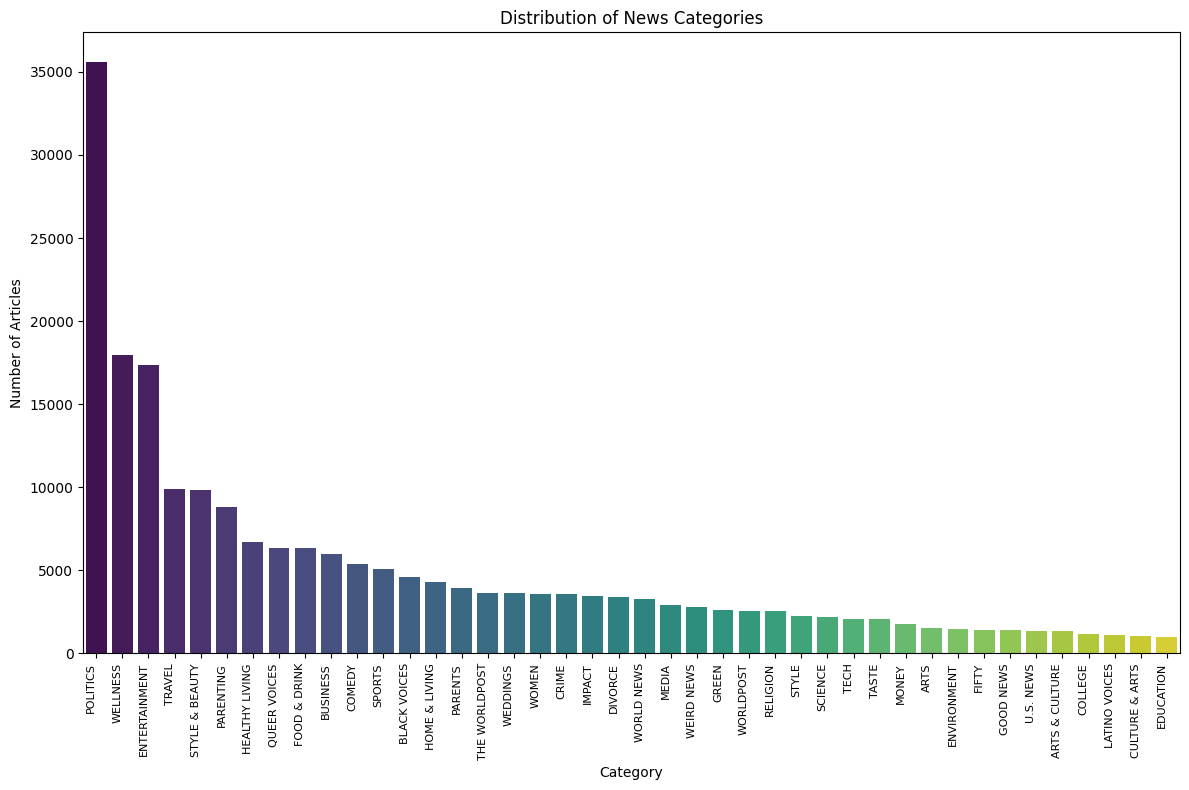


Number of unique categories: 42
Most common category: POLITICS with 35602 articles
Least common category: EDUCATION with 1014 articles

--- 2.3 Text Length Analysis ---


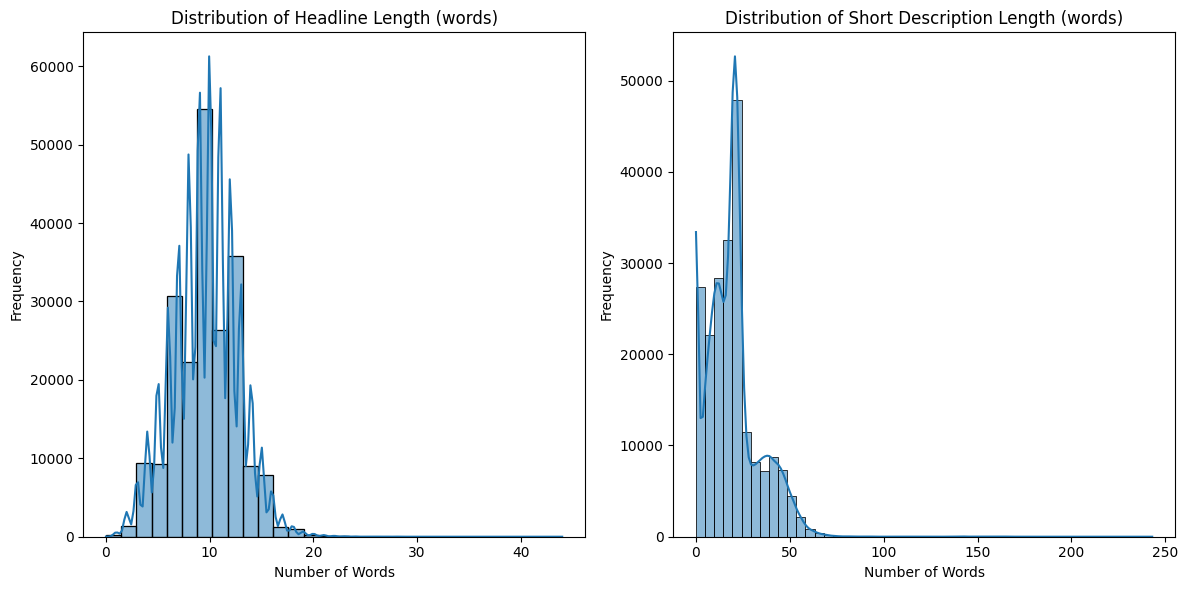


Headline Length Statistics:
count    209527.000000
mean          9.600744
std           3.068507
min           0.000000
25%           8.000000
50%          10.000000
75%          12.000000
max          44.000000
Name: headline_length, dtype: float64

Short Description Length Statistics:
count    209527.000000
mean         19.669026
std          14.152783
min           0.000000
25%          10.000000
50%          19.000000
75%          24.000000
max         243.000000
Name: description_length, dtype: float64

--- 2.4 Word Clouds ---
Generating word clouds for top 3 categories (headline + description)...


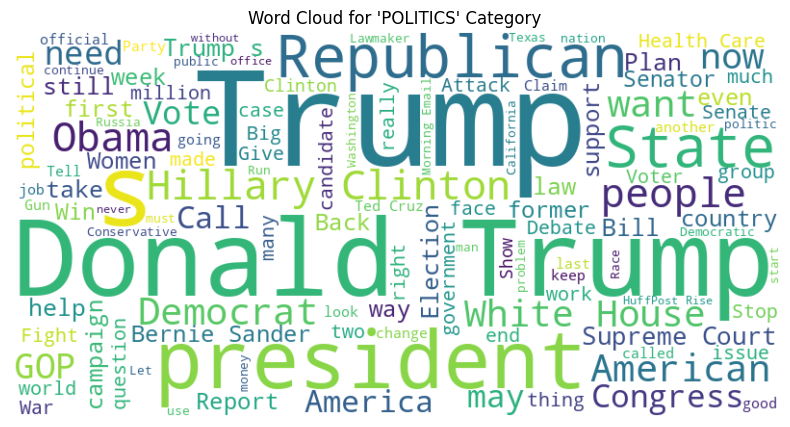

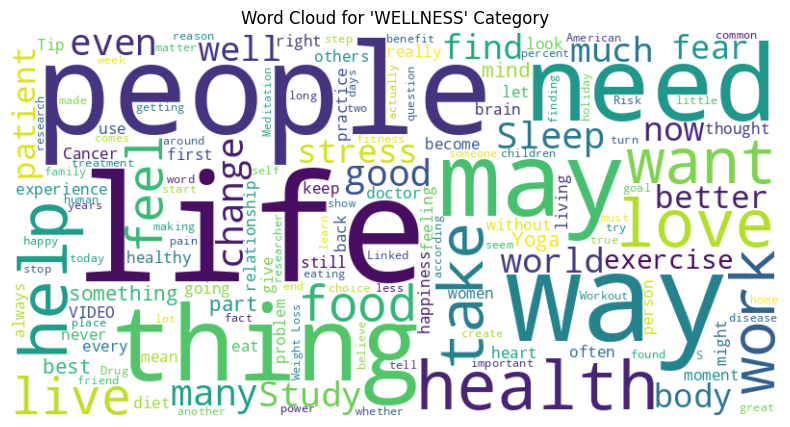

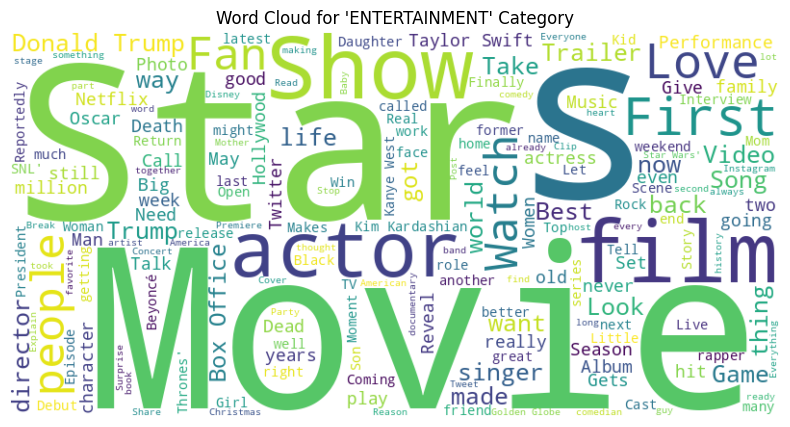


--- 2.5 Author Analysis ---
Number of unique authors/author groups: 29169
Too many unique authors to plot directly. Top 10:
authors
                    37418
Lee Moran            2954
Ron Dicker           2219
Ed Mazza             1590
Mary Papenfuss       1566
Reuters, Reuters     1563
Cole Delbyck         1266
Carly Ledbetter      1170
Curtis M. Wong       1146
Andy McDonald        1100
Name: count, dtype: int64

--- 2.6 Date Analysis (Temporal Trends) ---


C:\Users\Granbell\AppData\Local\Temp\ipykernel_1448\1984307007.py:156: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  articles_per_month = df_eda.resample('M').size() # 'M' for month end frequency


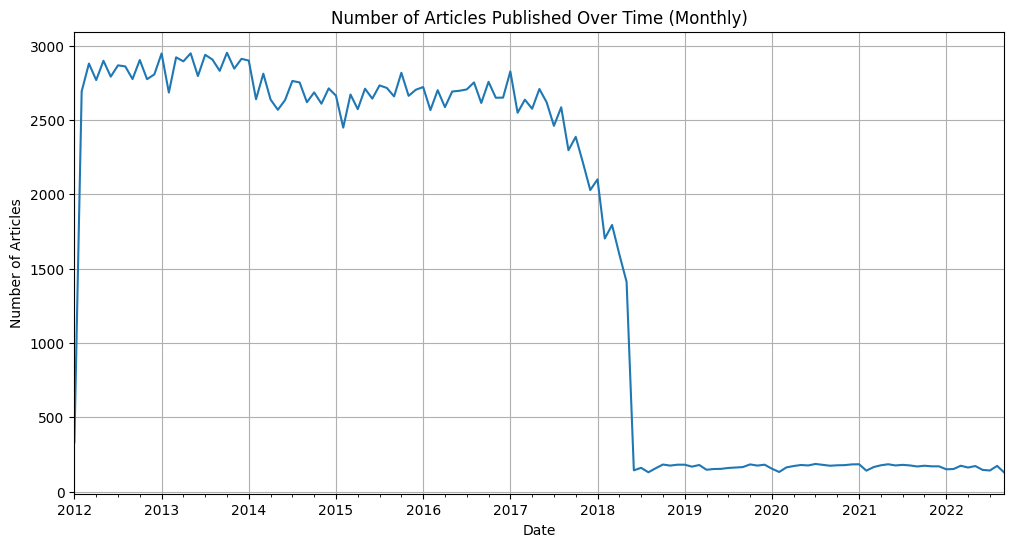


Articles per year:
date
2012-12-31    31355
2013-12-31    34583
2014-12-31    32339
2015-12-31    32006
2016-12-31    32098
2017-12-31    29889
2018-12-31     9734
2019-12-31     2005
2020-12-31     2054
2021-12-31     2066
2022-12-31     1398
Freq: YE-DEC, dtype: int64

--- EDA Complete ---

--- Starting Preprocessing for Modeling ---
Shape for modeling: (209527, 9)


C:\Users\Granbell\AppData\Local\Temp\ipykernel_1448\1984307007.py:166: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  print(df_eda.resample('Y').size())


Number of unique categories for modeling: 42
Train size: 146668
Validation size: 31429
Test size: 31430


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on device: cuda:0

--- Defining Learning Rate Scheduler ---


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
# from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, AdamW, get_scheduler # Original
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_scheduler # Corrected
from torch.optim import AdamW # Corrected AdamW import
from tqdm.auto import tqdm # For progress bars
from sklearn.metrics import accuracy_score, f1_score, classification_report

# --- EDA Specific Imports ---
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
# You might need to install wordcloud: pip install wordcloud
from wordcloud import WordCloud

# Configuration (same as before)
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
NUM_EPOCHS = 3
OUTPUT_DIR = "./news_distilbert_finetuned"
DATA_FILE_PATH = 'News_Category_Dataset_v3.json'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Load Data (Same as before) ---
df = pd.read_json(DATA_FILE_PATH, lines=True)
print(f"Original dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nDataset info:")
df.info()

# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- Starting Exploratory Data Analysis ---")

# 2.1. Basic Statistics and Missing Values
print("\n--- 2.1 Basic Statistics & Missing Values ---")
print("Dataset Description:")
print(df.describe(include='object')) # Describe object columns

print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows with missing critical values (headline, short_description, category)
# This is also part of your original preprocessing, good to confirm here
df_eda = df.dropna(subset=['headline', 'short_description', 'category']).copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"\nShape after dropping NaNs for EDA: {df_eda.shape}")

# 2.2. Category Distribution
print("\n--- 2.2 Category Distribution ---")
category_counts = df_eda['category'].value_counts()
print("Category Counts:")
print(category_counts)

plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90, ha='right', fontsize=8) # Rotate labels for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print(f"\nNumber of unique categories: {df_eda['category'].nunique()}")
print(f"Most common category: {category_counts.index[0]} with {category_counts.iloc[0]} articles")
print(f"Least common category: {category_counts.index[-1]} with {category_counts.iloc[-1]} articles")

# 2.3. Text Length Analysis
print("\n--- 2.3 Text Length Analysis ---")
df_eda['headline_length'] = df_eda['headline'].apply(lambda x: len(x.split()))
df_eda['description_length'] = df_eda['short_description'].apply(lambda x: len(str(x).split())) # str(x) to handle potential non-strings if any survived dropna

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_eda['headline_length'], kde=True, bins=30)
plt.title('Distribution of Headline Length (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_eda['description_length'], kde=True, bins=50)
plt.title('Distribution of Short Description Length (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\nHeadline Length Statistics:")
print(df_eda['headline_length'].describe())
print("\nShort Description Length Statistics:")
print(df_eda['description_length'].describe())

# 2.4. Word Clouds (for a few top categories)
print("\n--- 2.4 Word Clouds ---")
# Consider common English stop words
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["said", "will", "new", "one", "u", "us", "say", "says", "told", "year", "day", "time", "make", "get", "go", "know", "see", "come", "think"]) # Add custom stopwords

def generate_wordcloud(text_series, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          stopwords=stopwords,
                          min_font_size=10).generate(" ".join(text_series))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

print("Generating word clouds for top 3 categories (headline + description)...")
top_categories = category_counts.index[:3]
for category_name in top_categories:
    category_df = df_eda[df_eda['category'] == category_name]
    combined_text = category_df['headline'] + " " + category_df['short_description']
    generate_wordcloud(combined_text, f"Word Cloud for '{category_name}' Category")


# 2.5. Analysis of Authors (if interesting and not too many unique authors)
print("\n--- 2.5 Author Analysis ---")
if 'authors' in df_eda.columns:
    author_counts = df_eda['authors'].value_counts()
    print(f"Number of unique authors/author groups: {df_eda['authors'].nunique()}")
    if df_eda['authors'].nunique() < 200: # Only plot if manageable number
        print("\nTop 10 Authors/Author Groups:")
        print(author_counts.head(10))
        plt.figure(figsize=(10, 6))
        author_counts.head(10).plot(kind='bar')
        plt.title('Top 10 Authors/Author Groups by Number of Articles')
        plt.xlabel('Author(s)')
        plt.ylabel('Number of Articles')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("Too many unique authors to plot directly. Top 10:")
        print(author_counts.head(10))
else:
    print("Column 'authors' not found for analysis.")


# 2.6. Date Analysis (Temporal Trends)
print("\n--- 2.6 Date Analysis (Temporal Trends) ---")
if 'date' in df_eda.columns:
    df_eda['date'] = pd.to_datetime(df_eda['date'])
    df_eda.set_index('date', inplace=True) # Set date as index for easy resampling

    articles_per_month = df_eda.resample('M').size() # 'M' for month end frequency
    plt.figure(figsize=(12, 6))
    articles_per_month.plot()
    plt.title('Number of Articles Published Over Time (Monthly)')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')
    plt.grid(True)
    plt.show()

    print("\nArticles per year:")
    print(df_eda.resample('Y').size())

    # Reset index if you need 'date' as a column later for modeling features
    df_eda.reset_index(inplace=True)
else:
    print("Column 'date' not found for analysis.")


print("\n--- EDA Complete ---")
# At this point, df_eda contains your cleaned data with some new length features.
# For the rest of the modeling, you might want to revert to a cleaner df or use df_eda
# The original script used 'df' and re-did the dropna and text combination.
# We will proceed with 'df' as per the original script's structure.
# Re-assign 'df' to the cleaned version for consistency with the rest of your script
df = df_eda.copy() # Or use df_eda directly if you prefer


# --- 3. Preprocessing for Modeling (Starts here, using the cleaned 'df') ---
print("\n--- Starting Preprocessing for Modeling ---")
# Select relevant columns and combine text (already done for df_eda, ensure 'df' is the same)
# df = df[['headline', 'short_description', 'category']]
# df.dropna(subset=['headline', 'short_description', 'category'], inplace=True) # Already done
df['text'] = df['headline'] + " [SEP] " + df['short_description']
print(f"Shape for modeling: {df.shape}")

# Optional: For faster iteration, use a subset (ensure consistency if used in EDA)
# df = df.sample(n=20000, random_state=42)
# print(f"Using subset of shape for modeling: {df.shape}")

# Encode labels (categories)
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['category'])
num_labels = len(label_encoder.classes_)
print(f"Number of unique categories for modeling: {num_labels}")
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

# Split data into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=df['label_encoded']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")


# --- 4. Tokenization and PyTorch Datasets (Same as before) ---
# ... (rest of your code: tokenizer, NewsDataset, DataLoaders)
# In your Tokenization section (e.g., Step 4 in the full script)
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# IMPORTANT: Use return_tensors="pt" to get PyTorch tensors directly from the tokenizer.
# These tensors will initially be on the CPU.
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=MAX_LENGTH, return_tensors="pt")

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings # This is now a dict of PyTorch tensors (e.g., {'input_ids': tensor, 'attention_mask': tensor})
        self.labels = torch.tensor(labels) # Convert labels to a tensor upfront

    def __getitem__(self, idx):
        # Slicing PyTorch tensors directly yields tensors. No need for torch.tensor() here again.
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels) # Or self.encodings['input_ids'].shape[0]

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# --- 5. Load Model and Setup Training (Same as before) ---
# ... (rest of your code: model loading, optimizer, scheduler, compute_metrics)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
model.to(device)
print(f"Model loaded on device: {next(model.parameters()).device}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

def compute_metrics_fn(preds_ids, labels_ids):
    accuracy = accuracy_score(labels_ids, preds_ids)
    f1 = f1_score(labels_ids, preds_ids, average='weighted', zero_division=0)
    return {"accuracy": accuracy, "f1_weighted": f1}

# --- Define Learning Rate Scheduler (AFTER train_dataloader is created) ---
print("\n--- Defining Learning Rate Scheduler ---")
num_training_steps = NUM_EPOCHS * len(train_dataloader) # Now train_dataloader exists
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)